In [1]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from gspread_formatting import *
from collections import Counter
import numpy as np
import time

import pandas as pd
import geopandas as gpd
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import MaxNLocator

import itertools as it

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rc('axes', axisbelow=True)
%matplotlib inline

In [2]:
today = time.strftime("%Y-%m-%d")

month_dict = {'01':'Jan','02':'Feb','03':'Mar','04':'Apr','05':'May','06':'Jun',
              '07':'Jul','08':'Aug','09':'Sep','10':'Oct','11':'Nov','12':'Dec'}

weekday_mapping = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}

alldates = pd.date_range(start='2020-01-06', end='2021-12-31').tolist()
datelist = [str(i.date()) for i in alldates]
weekdays = [weekday_mapping[i.date().weekday()] for i in alldates]
weeklist = [i//7 for i in range(len(alldates))]
DATE_DF = pd.DataFrame({'date':datelist,'day':weekdays,'week':weeklist})
DATERANGE = DATE_DF['date'].tolist()

date_dict = {DATERANGE[i]:i for i in range(len(DATERANGE))}

In [3]:
# use creds to create a client to interact with the Google Drive API
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

creds = ServiceAccountCredentials.from_json_keyfile_name('../client_secret.json', scope)
client = gspread.authorize(creds)

mass_data = client.open("COVID-data_Massachusetts")
contact_data = mass_data.worksheet('contact_tracing')
city_data = mass_data.worksheet('town_data')
school_data = mass_data.worksheet('k12_schools')

contact_df = pd.DataFrame(contact_data.get_all_records(default_blank=np.nan))
city_df = pd.DataFrame(city_data.get_all_records(default_blank=np.nan))
school_df = pd.DataFrame(school_data.get_all_records(default_blank=np.nan))
school_df = school_df[['date','school_id','name',
                       'new_cases_students','new_cases_employee','details']].copy()

# contact_df.loc[contact_df['raw_new_clusters']=='','raw_new_clusters'] = np.nan
# contact_df.loc[contact_df['raw_new_cases']=='','raw_new_cases'] = np.nan
# contact_df.loc[contact_df['raw_new_contacts']=='','raw_new_contacts'] = np.nan
# contact_df.loc[contact_df['raw_total_cases']=='','raw_total_cases'] = np.nan
# contact_df.loc[contact_df['raw_total_contacts']=='','raw_total_contacts'] = np.nan

In [4]:
dat_shp = gpd.read_file('../../covid19-mobility/data/towns/').rename(columns={'TOWN':'city'})
city_df['city'] = city_df['city'].str.upper()

/usr/local/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


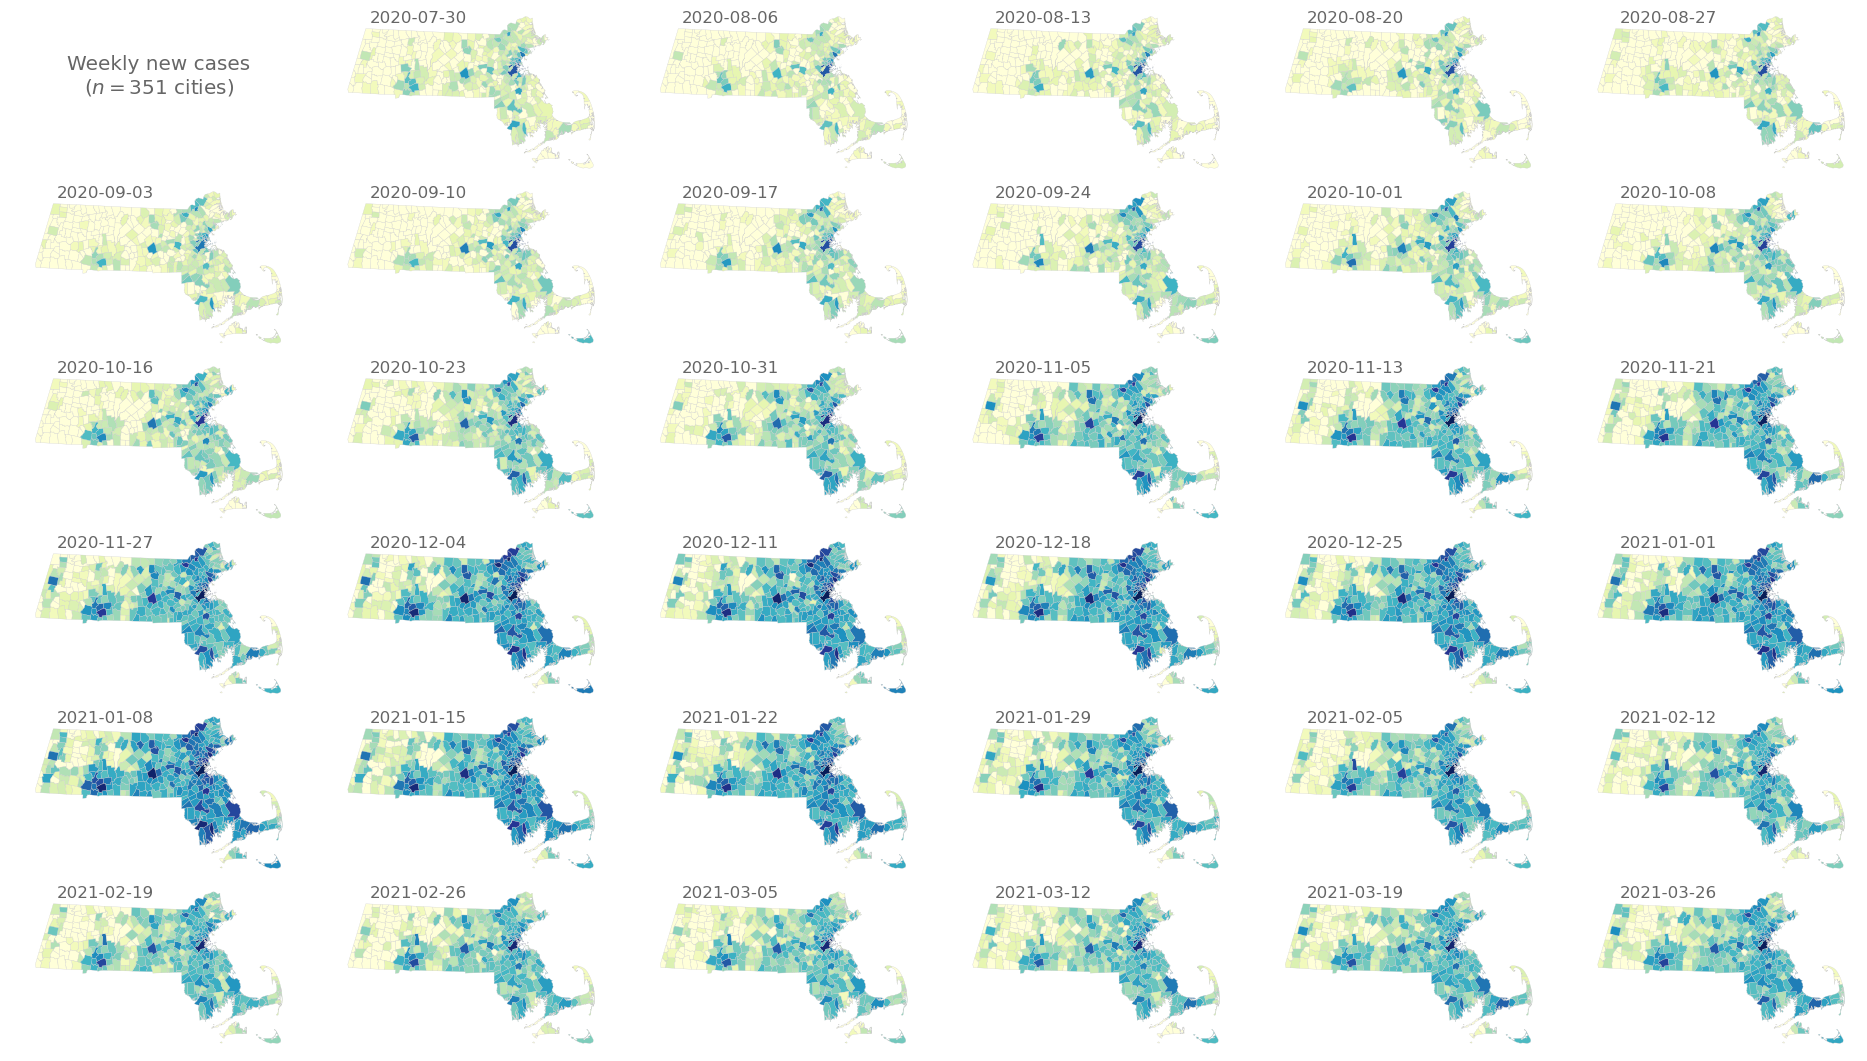

In [5]:
w = 4.0; h = 2.3
ncols = 6; nrows = 6
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100)#, sharex=True)
plt.subplots_adjust(wspace=0.05,hspace=0.05)

for di, d in enumerate(list(city_df['date'].unique())[-int(nrows*ncols):]):
    aa = ax[tups[di]]
    if di != 0:
        aa = ax[tups[di]]
        dat_shp_i = dat_shp.copy()
        dat_shp_i = dat_shp_i.merge(city_df.loc[city_df['date']==d][['city','new_cases_town']],
                                    how='left', on='city')
        dat_shp_i['new_cases_town'] = np.log(dat_shp_i['new_cases_town']+1)
        dat_shp_i.plot(ax=aa, column='new_cases_town', ec='.8', lw=0.2, cmap='YlGnBu', vmin=0, vmax=7.5)
        aa.text(0.125, 0.95, d, ha='left', va='center',
                transform=aa.transAxes, color='.4', fontsize='large')

    else:
        aa.text(0.5, 0.6, 'Weekly new cases\n($n=%i$ cities)'%city_df['city'].nunique(), color='.4',
                ha='center', va='center', transform=aa.transAxes, fontsize='x-large')

    aa.set_axis_off()

for dr in range(len(tups)-(di+1)):
    ax[tups[di + 1 + dr]].set_axis_off()


plt.savefig('../figs/pngs/ma_cities_casecounts_over_time.png',dpi=425,bbox_inches='tight')
plt.show()

/usr/local/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


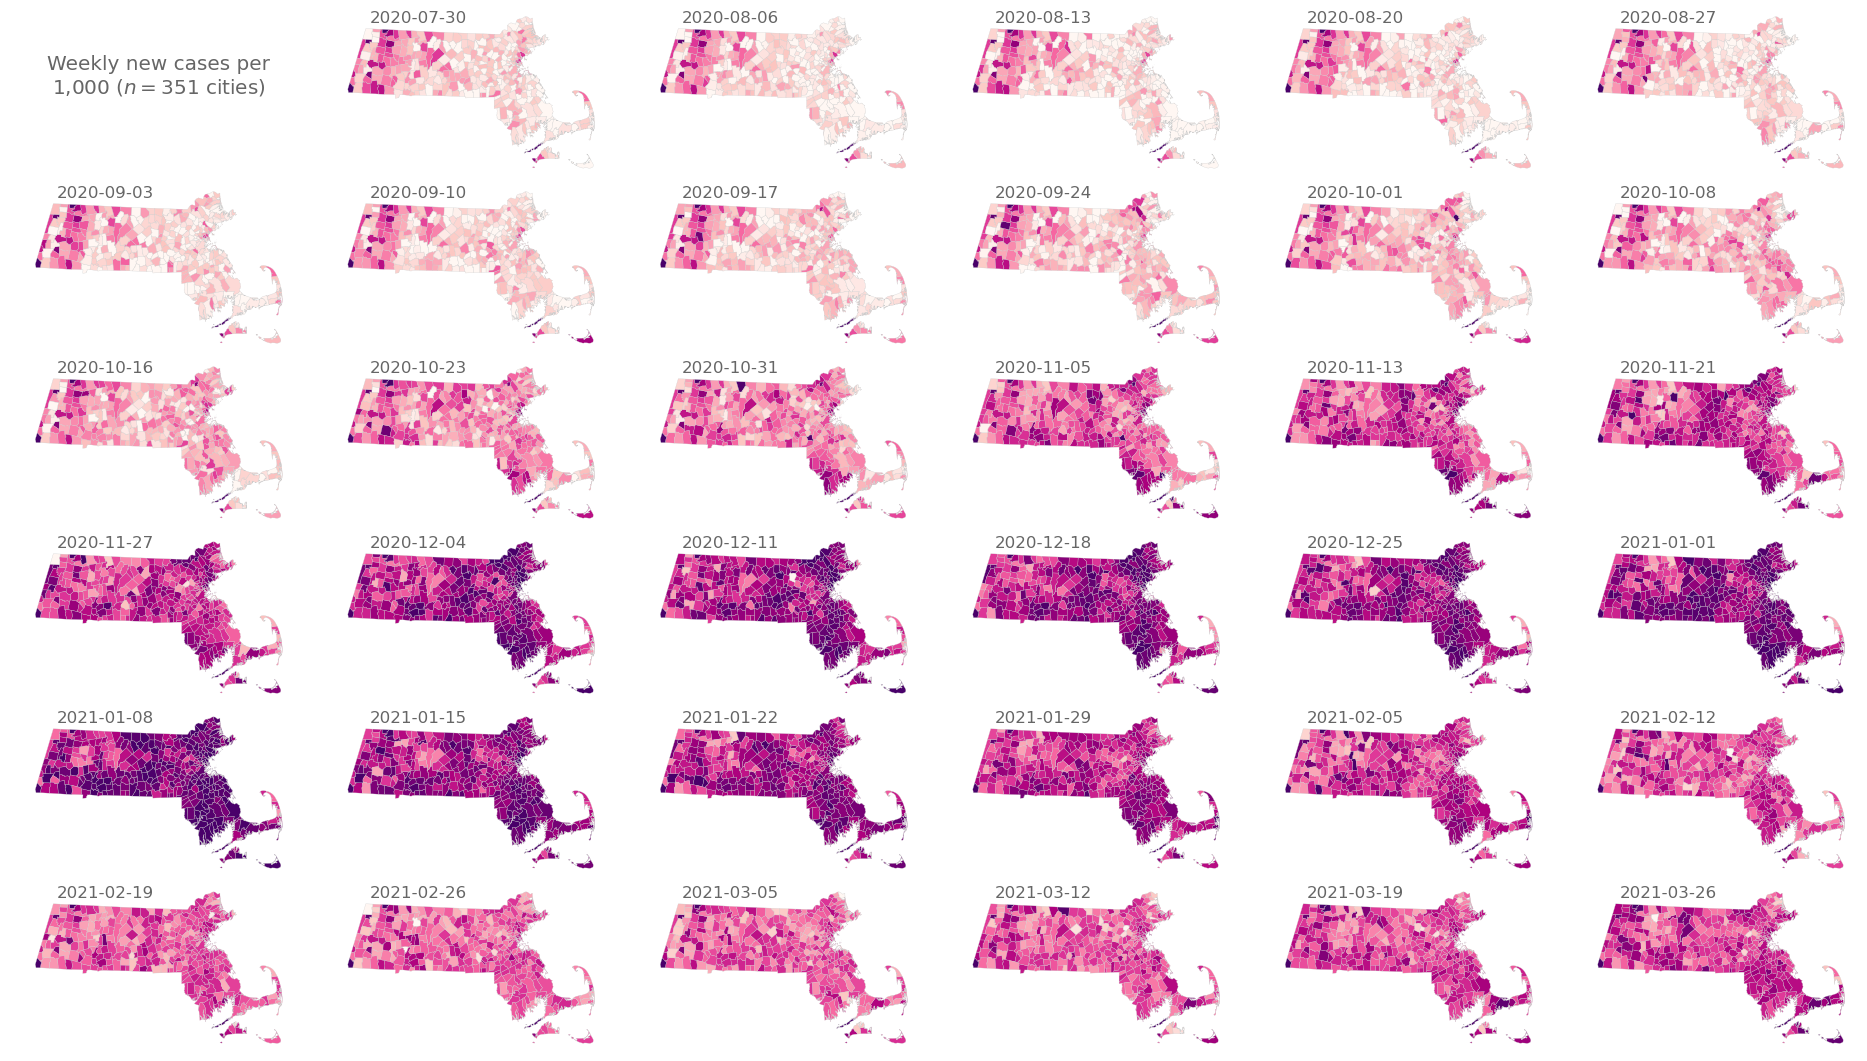

In [6]:
w = 4.0; h = 2.3
ncols = 6; nrows = 6
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100)#, sharex=True)
plt.subplots_adjust(wspace=0.05,hspace=0.05)

for di, d in enumerate(list(city_df['date'].unique())[-int(nrows*ncols):]):
    aa = ax[tups[di]]
    if di != 0:
        aa = ax[tups[di]]
        dat_shp_i = dat_shp.copy()
        dat_shp_i = dat_shp_i.merge(city_df.loc[city_df['date']==d][['city','new_cases_town','population']],
                                    how='left', on='city')
        dat_shp_i['new_cases_town'] = np.log((dat_shp_i['new_cases_town']+1) / (dat_shp_i['population']+1) * 1000)
        dat_shp_i.plot(ax=aa, column='new_cases_town', ec='.8', lw=0.2, cmap='RdPu', vmin=-2.0, vmax=2.0)
        aa.text(0.125, 0.95, d, ha='left', va='center',
                transform=aa.transAxes, color='.4', fontsize='large')

    else:
        aa.text(0.5, 0.6, 'Weekly new cases per\n1,000 ($n=%i$ cities)'%city_df['city'].nunique(), color='.4',
                ha='center', va='center', transform=aa.transAxes, fontsize='x-large')

    aa.set_axis_off()

for dr in range(len(tups)-(di+1)):
    ax[tups[di + 1 + dr]].set_axis_off()

plt.savefig('../figs/pngs/ma_cities_casecounts_per1000_over_time.png',dpi=425,bbox_inches='tight')

plt.show()

In [7]:
widx = 3
city_dfx = []
for city in city_df['city'].unique():
    cf = city_df.loc[city_df['city']==city].copy()
    cf['new_cases_town'] = np.nan_to_num(cf['new_cases_town'].rolling(window=widx).mean())
    city_dfx.append(cf)
    
city_dfx = pd.concat(city_dfx).reset_index().iloc[:,1:]

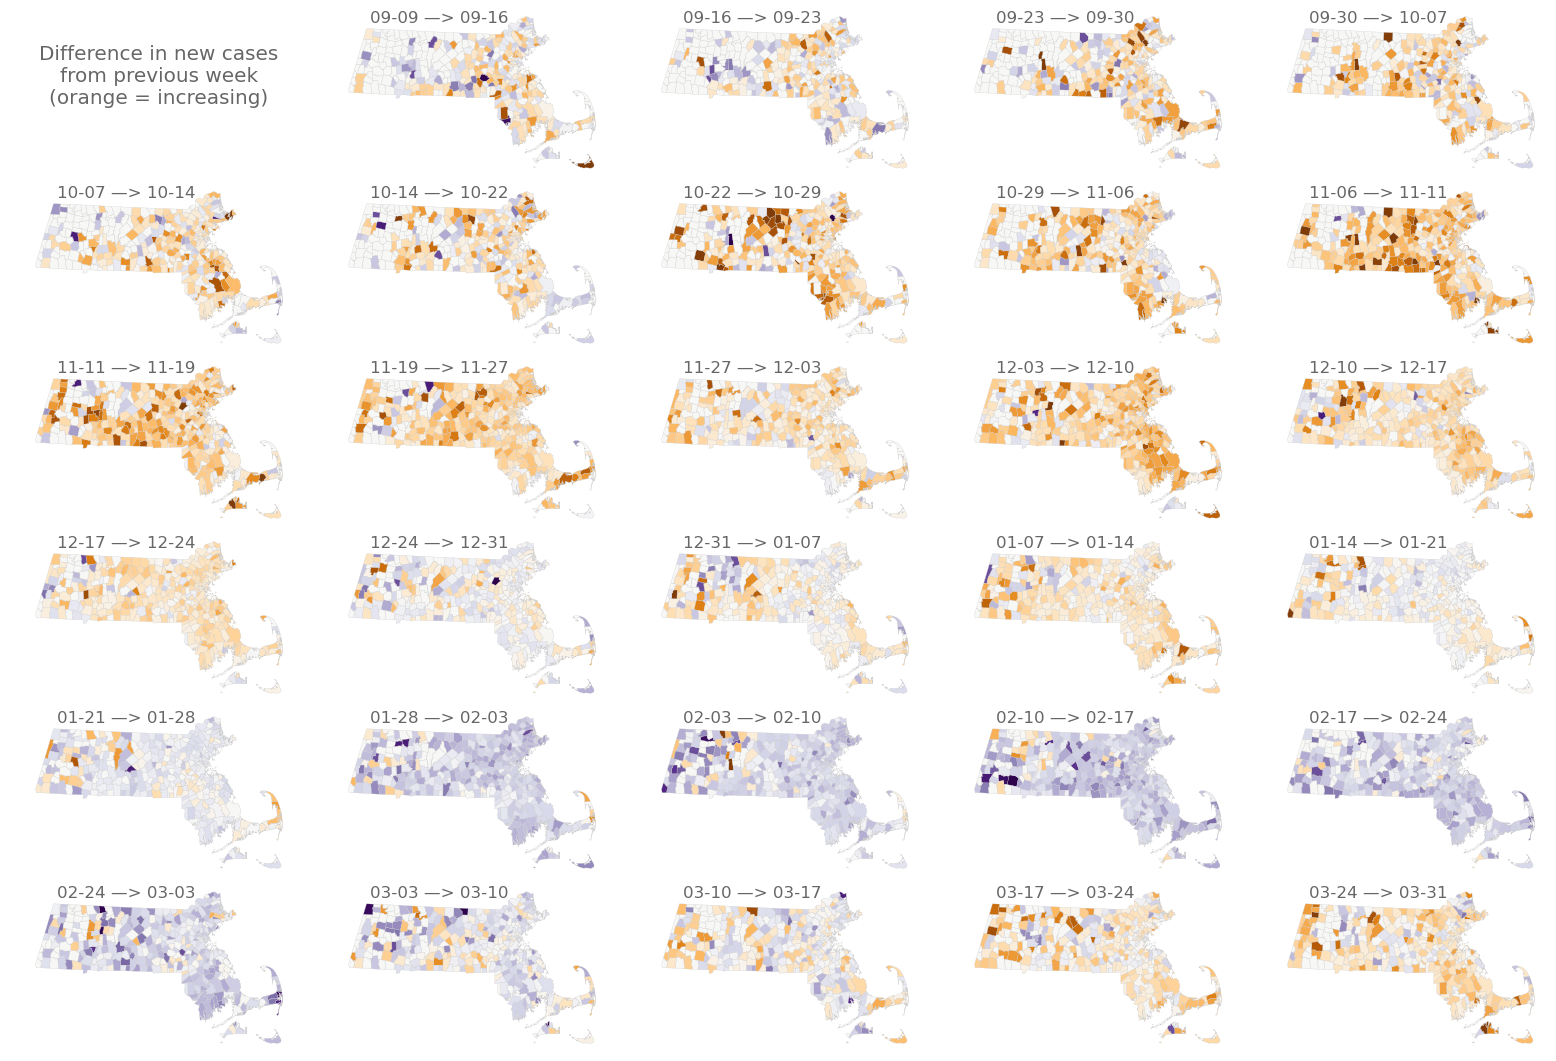

In [8]:
w = 4.0; h = 2.3
ncols = 5; nrows = 6
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100)#, sharex=True)
plt.subplots_adjust(wspace=0.05,hspace=0.05)

for di, dcurr in enumerate(list(city_dfx['as_of'].unique())[-int(nrows*ncols):]):
    aa = ax[tups[di]]
    if di > 0:#widx-1:
        dprev = list(city_dfx['as_of'].unique())[-int(nrows*ncols):][di-1]
        dat_shp_i = dat_shp.copy()
        dat_shp_i = dat_shp_i.merge(city_dfx.loc[city_dfx['as_of']==dcurr][['city','new_cases_town']],
                        how='left', on='city').rename(columns={'new_cases_town':'new_cases_town_curr'})
        dat_shp_i['new_cases_town_curr'] = np.log(dat_shp_i['new_cases_town_curr']+1)
        dat_shp_i = dat_shp_i.merge(city_dfx.loc[city_dfx['as_of']==dprev][['city','new_cases_town']], 
                        how='left', on='city').rename(columns={'new_cases_town':'new_cases_town_prev'})
        dat_shp_i['new_cases_town_prev'] = np.log(dat_shp_i['new_cases_town_prev']+1)

        dat_shp_i['diff'] = dat_shp_i['new_cases_town_curr'] - dat_shp_i['new_cases_town_prev']

        dat_shp_i.plot(ax=aa, column='diff', ec='.8', lw=0.2, cmap='PuOr_r', vmin=-1.0, vmax=1.0)
        aa.text(0.125, 0.95, dprev[5:]+" —> "+dcurr[5:], ha='left', va='center',
                transform=aa.transAxes, color='.4', fontsize='large')
    elif di == 0:
        aa.text(0.5, 0.6, 'Difference in new cases\nfrom previous week\n(orange = increasing)',
                ha='center', va='center', transform=aa.transAxes, color='.4', fontsize='x-large')
        
    aa.set_axis_off()

for dr in range(len(tups)-(di+1)):
    ax[tups[di + 1 + dr]].set_axis_off()


plt.savefig('../figs/pngs/ma_cities_casecounts_over_time_diff2.png',dpi=425,bbox_inches='tight')

plt.show()

In [9]:
city_df['new_cases_per1000_town'] = city_df['new_cases_town'] / city_df['population'] * 1000

eligible_df = city_df.loc[(city_df['date']==city_df['date'].max())&\
                          (city_df['total_cases']>np.quantile(city_df['total_cases'],0.9))].copy()
rank_last4weeks = city_df.loc[(city_df['date'].isin(city_df['date'].unique()[-4:]))&\
                              (city_df['city'].isin(eligible_df['city'].values))].groupby('city').agg(
        {'new_cases_town':'mean'}).reset_index().sort_values('new_cases_town',ascending=False)

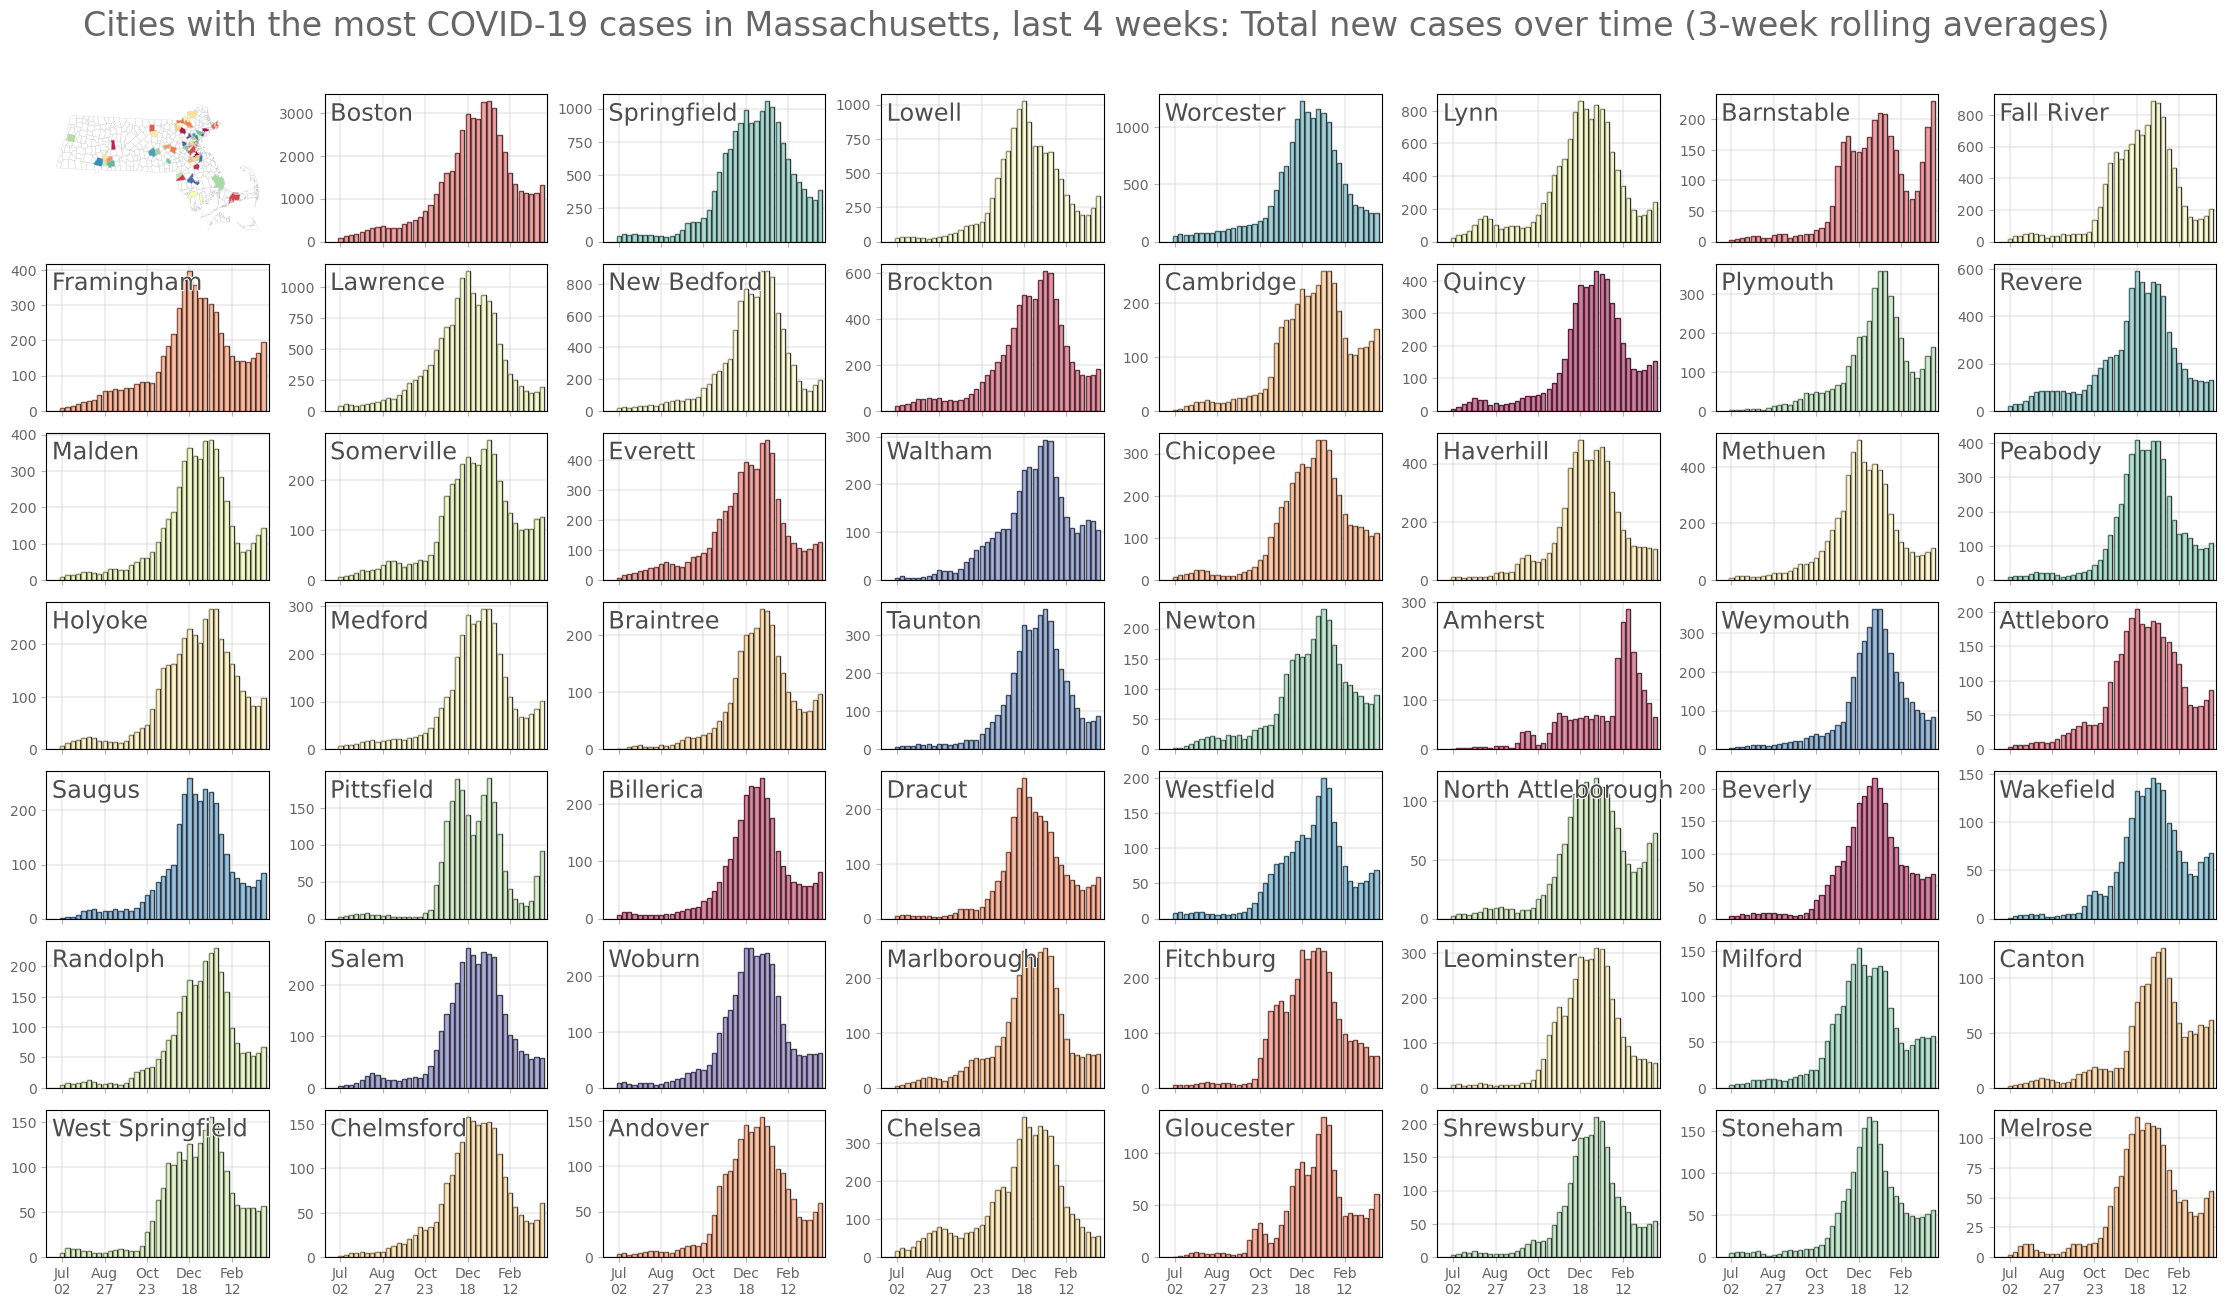

In [10]:
cmaa = plt.cm.Spectral

w = 3.5; h = 2.2
ncols = 8; nrows = 7
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100)#, sharex=True)
plt.subplots_adjust(wspace=0.25,hspace=0.15)

dat_shp.plot(ax=ax[tups[0]], ec='.8', fc='none', lw=0.2)
dat_shp_i = dat_shp.loc[dat_shp['city'].isin(rank_last4weeks['city'].values[:(nrows*ncols)-1])].copy()
dat_shp_i = dat_shp_i.reset_index().iloc[:,1:]
dat_shp_i['col'] = list(range(dat_shp_i.shape[0]))
dat_shp_i.plot(ax=ax[tups[0]], ec='.8', lw=0.2, column='col', cmap=cmaa)
ax[tups[0]].set_axis_off()

cols = cmaa(dat_shp_i['col'].values/dat_shp_i['col'].max())
cols = dict(zip(dat_shp_i['city'].values,cols))

for ci, city_i in enumerate(rank_last4weeks['city'].values[:(nrows*ncols)-1]):
    aa = ax[tups[ci+1]]
    cti = city_df.loc[city_df['city']==city_i].copy()
    xvals_i = list(range(len(cti['new_cases_per1000_town'])))
    yvals_i = cti['new_cases_per1000_town'].values
    yvals_i = cti['new_cases_town'].rolling(window=3).mean().values
    aa.bar(xvals_i, yvals_i, fc='w', ec='.2')
    aa.bar(xvals_i, yvals_i, fc=cols[city_i], ec='none',alpha=0.5)

    title_i = " ".join([i.capitalize() for i in city_i.split(' ')])

    aa.text(0.025,0.95,title_i,ha='left',va='top',transform=aa.transAxes,fontsize='xx-large',color='.3',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'), path_effects.Normal()])
    aa.grid(linewidth=1.5,color='.75',alpha=0.25)
    aa.tick_params(labelcolor='.4',color='.7',labelsize='medium')
    aa.set_xticks([i for i in list(range(cti['date'].nunique()))[2::8]])
    if tups[ci+1][0] == nrows-1:
        aa.set_xticklabels([month_dict[i[5:7]]+"\n%s"%i[8:] for i in cti['date'].unique()[2::8]])
        
    else:
        aa.set_xticklabels(['' for i in list(range(cti['date'].nunique()))[2::8]])
        
    aa.set_xlim(list(range(city_df['date'].nunique()))[0]-1,list(range(city_df['date'].nunique()))[-1]+1)

plt.suptitle('Cities with the most COVID-19 cases in Massachusetts, last 4 weeks: '+\
             'Total new cases over time (3-week rolling averages)', y=0.935, fontsize=24,
             color='.4')

plt.savefig('../figs/pngs/ma_cities_last4weeks_ranking.png',dpi=425,bbox_inches='tight')

plt.show()

In [11]:
# cmaa = plt.cm.Spectral

# w = 3.5; h = 2.2
# ncols = 8; nrows = 7
# tups = list(it.product(range(nrows), range(ncols)))
# fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100)#, sharex=True)
# plt.subplots_adjust(wspace=0.25,hspace=0.15)

# dat_shp.plot(ax=ax[tups[0]], ec='.8', fc='none', lw=0.2)
# dat_shp_i = dat_shp.loc[dat_shp['city'].isin(rank_last4weeks['city'].values[:(nrows*ncols)-1])].copy()
# dat_shp_i = dat_shp_i.reset_index().iloc[:,1:]
# dat_shp_i['col'] = list(range(dat_shp_i.shape[0]))
# dat_shp_i.plot(ax=ax[tups[0]], ec='.8', lw=0.2, column='col', cmap=cmaa)
# ax[tups[0]].set_axis_off()

# cols = cmaa(dat_shp_i['col'].values/dat_shp_i['col'].max())
# cols = dict(zip(dat_shp_i['city'].values,cols))

# for ci, city_i in enumerate(rank_last4weeks['city'].values[:(nrows*ncols)-1]):
#     aa = ax[tups[ci+1]]
#     cti = city_df.loc[city_df['city']==city_i].copy()
#     xvals_i = list(range(len(cti['new_cases_per1000_town'])))
#     yvals_i = cti['new_cases_per1000_town'].values
#     yvals_i = cti['new_cases_town'].rolling(window=3).mean().values
#     yvals_i = yvals_i / np.nansum(yvals_i)
#     aa.bar(xvals_i, yvals_i, fc='w', ec='.2')
#     aa.bar(xvals_i, yvals_i, fc=cols[city_i], ec='none',alpha=0.5)

#     title_i = " ".join([i.capitalize() for i in city_i.split(' ')])

#     aa.text(0.025,0.95,title_i,ha='left',va='top',transform=aa.transAxes,fontsize='xx-large',color='.3',
#             path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'), path_effects.Normal()])
#     aa.grid(linewidth=1.5,color='.75',alpha=0.25)
#     aa.tick_params(labelcolor='.4',color='.7',labelsize='medium')
#     aa.set_xticks([i for i in list(range(cti['date'].nunique()))[2::8]])
#     if tups[ci+1][0] == nrows-1:
#         aa.set_xticklabels([month_dict[i[5:7]]+"\n%s"%i[8:] for i in cti['date'].unique()[2::8]])
        
#     else:
#         aa.set_xticklabels(['' for i in list(range(cti['date'].nunique()))[2::8]])
        

#     aa.set_ylim(0, 0.17)
#     aa.set_xlim(list(range(city_df['date'].nunique()))[0]-1,list(range(city_df['date'].nunique()))[-1]+1)

# plt.suptitle('Cities with the most COVID-19 cases in Massachusetts, last 4 weeks: '+\
#              'Fraction of total cases over time (3-week rolling averages)', y=0.935, fontsize=24,
#              color='.4')

# plt.savefig('../figs/pngs/ma_cities_last4weeks_ranking_frac.png',dpi=425,bbox_inches='tight')

# plt.show()

In [12]:
heatm = []
city_order = city_df.loc[city_df['date']==city_df['date'].max()].sort_values('total_cases').city.values[::-1]
for ci, city_i in enumerate(city_order):
    cti = city_df.loc[city_df['city']==city_i].copy()
    yvals_i = cti['new_cases_per1000_town'].rolling(window=3).mean().values
    if sum(cti['new_cases_town'])>10:
        heatm.append(yvals_i)
    else:
        heatm.append(np.zeros(cti.shape[0]))

In [13]:
import cmocean as cmo

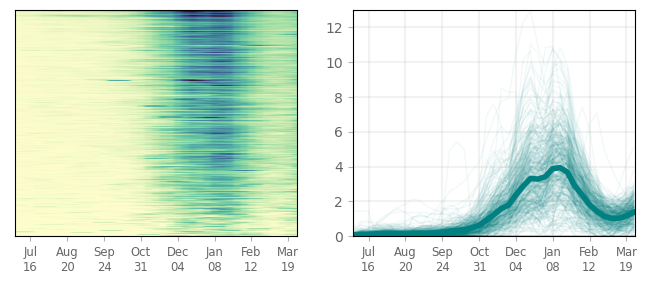

In [14]:
fig, ax = plt.subplots(1,2,figsize=(8,3),dpi=100)

ax[0].imshow(np.array(heatm),aspect='auto',vmin=0, vmax=10, cmap=cmo.cm.deep)
ax[1].plot(np.array(heatm).T, color='teal', alpha=0.05, lw=1)
ax[1].plot(np.mean(heatm,axis=0), color='teal', lw=4)
# ax.set_yticks(list(range(len(city_order)))[::10])
# ax.set_yticklabels(city_order[::10], fontsize='xx-small')
ax[0].set_yticks([])

ax[0].set_ylim(330,0)
ax[1].set_ylim(0,13)
ax[0].set_xlim(1.9,len(np.mean(heatm,axis=0))-0.85)
ax[1].set_xlim(1.9,len(np.mean(heatm,axis=0))-0.85)
ax[1].grid(linewidth=1.5,color='.75',alpha=0.2)
for a in fig.axes:
    a.tick_params(labelcolor='.4',color='.7',labelsize='medium')
    a.set_xticks([i for i in list(range(cti['date'].nunique()))[4::5]])
    a.set_xticklabels([month_dict[i[5:7]]+"\n%s"%i[8:] for i in cti['date'].unique()[4::5]],fontsize='small')

plt.savefig('../figs/pngs/ma_heatmap_city_cases.png',dpi=425,bbox_inches='tight')

plt.show()

In [15]:
city_df['city'] = city_df['city'].str.capitalize()

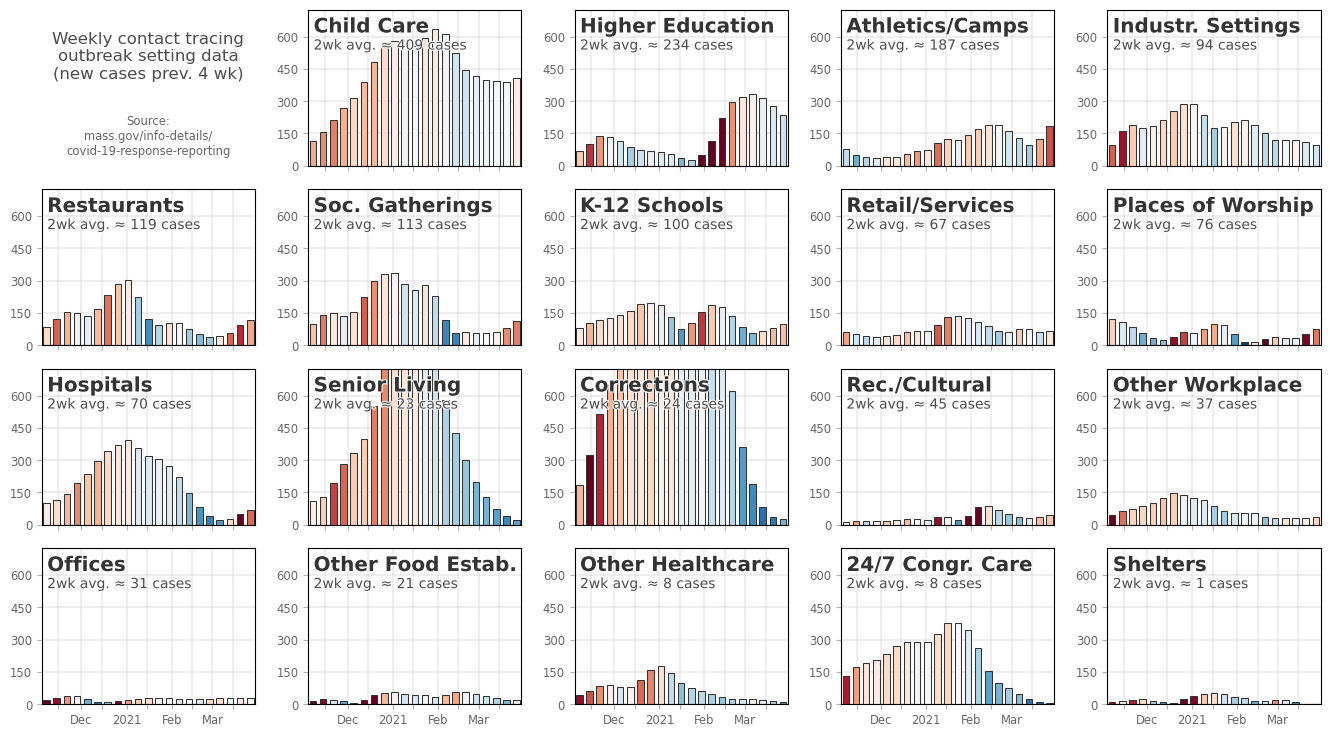

In [16]:
import matplotlib
wid = 2
barw = 4.5
w = 3.3; h = 2.3
ncols = 5; nrows = 4
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True)#, sharey=True)
plt.subplots_adjust(wspace=0.25,hspace=0.15)

labs = dict(zip(contact_df['setting'].unique(),['24/7 Congr. Care', 'Child Care',
       'Higher Education', 'Corrections', 'Hospitals', 'Household',
       'Industr. Settings', 'K-12 Schools', 'Long Term Care',
       'Offices', 'Athletics/Camps', 'Other',
       'Other Food Estab.', 'Other Healthcare',
       'Other Workplace', 'Places of Worship', 'Rec./Cultural',
       'Restaurants', 'Retail/Services', 'Senior Living',
       'Shelters', 'Soc. Gatherings', 'Travel/Lodging']))

ncats = contact_df['setting'].nunique()
dates_tt = ['2020-11-01','2020-11-15','2020-12-01','2020-12-15',
            '2021-01-01','2021-01-15','2021-02-01','2021-02-15','2021-03-01','2021-03-15']
dates_ll = ['Nov','','Dec','','2021','','Feb','','Mar','']
# dates_tt = ['2020-11-01','2020-12-01','2021-01-01','2021-02-01','2021-03-01']
# dates_ll = ['Nov','Dec','2021','Feb','Mar']

settings_order = contact_df.loc[contact_df['end_date'].isin(
                            sorted(contact_df['end_date'].unique())[-2:])].copy()
settings_order = settings_order.groupby('setting').agg({'raw_total_cases':'sum'}).reset_index()
settings_order = settings_order.sort_values('raw_total_cases',ascending=False)['setting'].unique()
settings_order = [i for i in settings_order
                  if i not in ['Household','Shelters', 'Other', 'Travel & Lodging']]
settings_order = ['Child Care','Colleges & Universities','Organized Athletics & Camps',
                  'Industrial Settings', 'Restaurants & Food Courts', 'Social Gatherings',
                  'K-12 Schools', 'Retail & Services', 'Places of Worship', 'Hospitals',
                  'Senior Living', 'Corrections',
                  'Recreation/Cultural', 'Other Workplaces', 'Offices', 'Other Food Establishments',
                  'Other Healthcare','24/7 Congregate Settings','Shelters']

for di, dcurr in enumerate(settings_order):
    di += 1
    aa = ax[tups[di]]
    cti = contact_df.loc[contact_df['setting']==dcurr].copy()

    norm = matplotlib.colors.Normalize(vmin=-0.75, vmax=0.75)    
    cvals = norm(np.nan_to_num(cti['raw_total_cases'].rolling(window=wid).mean().pct_change().values))
    col = plt.cm.RdBu_r(cvals)
    aa.bar([date_dict[i] for i in cti['end_date']], cti['raw_total_cases'].rolling(window=wid).mean(),
           color=col, ec='.2', width=barw, lw=0.75)
    
    four_wmean = np.nanmean(np.nan_to_num(cti['raw_total_cases'].values)[-2:])
    aa.text(0.025,0.95,labs[dcurr],ha='left',va='top',
            transform=aa.transAxes,fontsize='x-large',color='.2',fontweight='bold',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),
                          path_effects.Normal()])
    aa.text(0.025,0.815,'2wk avg. ≈ %i cases'%(four_wmean),
            ha='left', va='top',transform=aa.transAxes, fontsize='medium',color='.3',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),
                          path_effects.Normal()])

    aa.grid(linewidth=1.5,color='.75',alpha=0.25)
    aa.tick_params(labelcolor='.4',color='.7',labelsize='small')

    aa.set_xticks([date_dict[i] for i in dates_tt])
    aa.set_xticklabels(dates_ll)
    aa.set_xlim(date_dict[contact_df['end_date'].min()]-barw/2-1+wid*7,
                date_dict[contact_df['end_date'].max()]+barw/2+1)
    aa.yaxis.set_major_locator(MaxNLocator(integer=True, nbins='auto'))
    ylims = aa.get_ylim()
    ydiff = ylims[1] - ylims[0]
    aa.set_ylim(ylims[0], ylims[1]+ydiff*0.35)
    aa.set_ylim(0, 725)

aa = ax[tups[0]]
aa.text(0.5, 0.70, 'Weekly contact tracing\noutbreak setting data\n(new cases prev. 4 wk)',
        ha='center', va='center', transform=aa.transAxes, color='.3', fontsize='large')
aa.text(0.5, 0.05, 'Source:\nmass.gov/info-details/\ncovid-19-response-reporting',
        ha='center', va='bottom', transform=aa.transAxes, color='.4', fontsize='small')

aa.set_axis_off()

plt.savefig('../figs/pngs/ma_outbreak_settings_totcases_all.png',dpi=425,bbox_inches='tight')
plt.savefig('../figs/pdfs/ma_outbreak_settings_totcases_all.pdf',bbox_inches='tight')

plt.show()

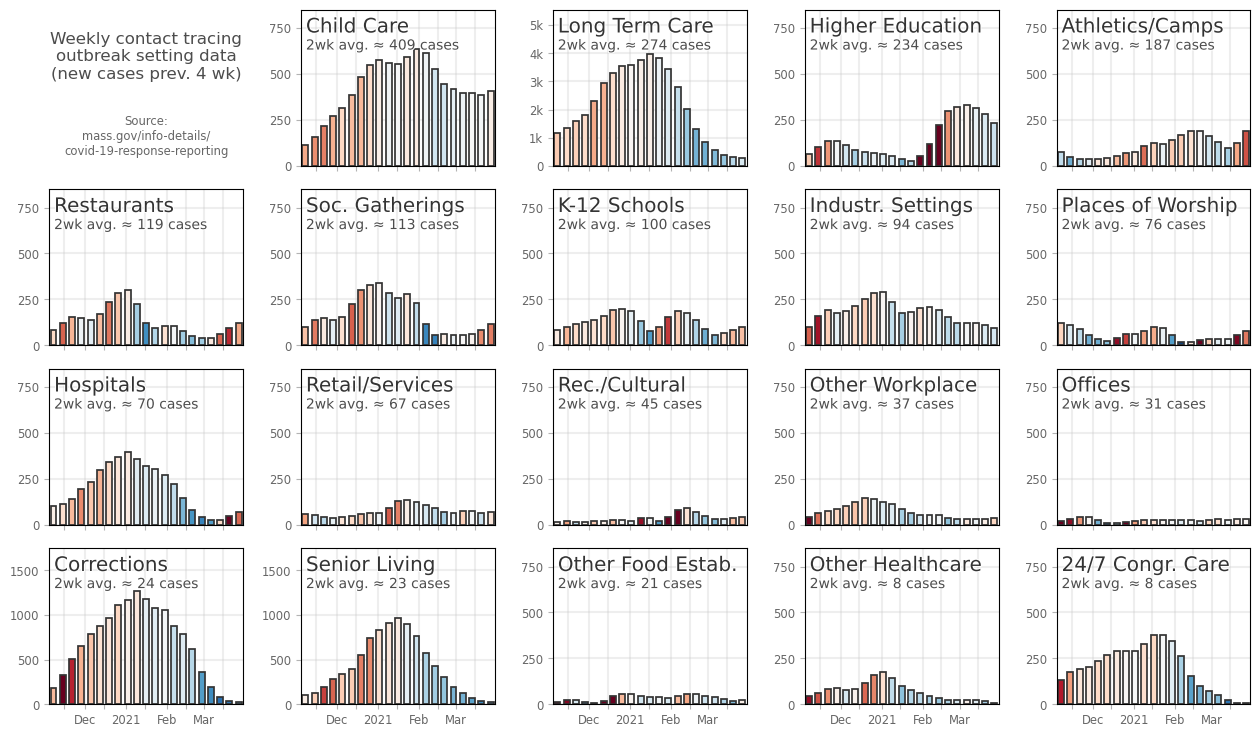

In [17]:
wid = 2
barw = 4.5
w = 3.1; h = 2.3
ncols = 5; nrows = 4
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True)#, sharey=True)
plt.subplots_adjust(wspace=0.3,hspace=0.15)

labs = dict(zip(contact_df['setting'].unique(),['24/7 Congr. Care', 'Child Care',
       'Higher Education', 'Corrections', 'Hospitals', 'Household',
       'Industr. Settings', 'K-12 Schools', 'Long Term Care',
       'Offices', 'Athletics/Camps', 'Other',
       'Other Food Estab.', 'Other Healthcare',
       'Other Workplace', 'Places of Worship', 'Rec./Cultural',
       'Restaurants', 'Retail/Services', 'Senior Living',
       'Shelters', 'Soc. Gatherings', 'Travel/Lodging']))

ncats = contact_df['setting'].nunique()
dates_tt = ['2020-11-01','2020-11-15','2020-12-01','2020-12-15',
            '2021-01-01','2021-01-15','2021-02-01','2021-02-15','2021-03-01','2021-03-15','2021-04-01']
dates_ll = ['Nov','','Dec','','2021','','Feb','','Mar','','Apr']
# dates_tt = ['2020-11-01','2020-12-01','2021-01-01','2021-02-01','2021-03-01']
# dates_ll = ['Nov','Dec','2021','Feb','Mar']

settings_order = contact_df.loc[contact_df['end_date']==contact_df['end_date'].max()\
                   ].sort_values('raw_total_cases',ascending=False)['setting'].unique()
settings_order = contact_df.loc[contact_df['end_date'].isin(
                            sorted(contact_df['end_date'].unique())[-2:])].copy()
settings_order = settings_order.groupby('setting').agg({'raw_total_cases':'sum'}).reset_index()
settings_order = settings_order.sort_values('raw_total_cases',ascending=False)['setting'].unique()
settings_order = [i for i in settings_order if i != 'Household']

for di, dcurr in enumerate(settings_order[1:-3]):
    di += 1
    aa = ax[tups[di]]
    cti = contact_df.loc[contact_df['setting']==dcurr].copy()

    norm = matplotlib.colors.Normalize(vmin=-0.75, vmax=0.75)
    cvals = norm(np.nan_to_num(cti['raw_total_cases'].rolling(window=wid).mean().pct_change().values))
    col = plt.cm.RdBu_r(cvals)
    
    aa.bar([date_dict[i] for i in cti['end_date']], cti['raw_total_cases'].rolling(window=wid).mean(),
           color=col, ec='.2', width=barw, lw=1.25)
    
    aa.text(0.025,0.95,labs[dcurr],ha='left',va='top',
            transform=aa.transAxes,fontsize='x-large',color='.2',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),
                          path_effects.Normal()])
    four_wmean = np.nanmean(np.nan_to_num(cti['raw_total_cases'].values)[-2:])
    aa.text(0.025,0.815,'2wk avg. ≈ %i cases'%(four_wmean),
            ha='left', va='top',transform=aa.transAxes, fontsize='medium',color='.3',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),
                          path_effects.Normal()])

    aa.grid(linewidth=1.5,color='.75',alpha=0.25)
    aa.tick_params(labelcolor='.4',color='.7',labelsize='small')

    aa.set_xticks([date_dict[i] for i in dates_tt])
    aa.set_xticklabels(dates_ll)
    aa.set_xlim(date_dict[contact_df['end_date'].min()]-barw/2-1+wid*7,
                date_dict[contact_df['end_date'].max()]+barw/2+1)
    aa.yaxis.set_major_locator(MaxNLocator(integer=True, nbins='auto'))
    ylims = aa.get_ylim()
    ydiff = ylims[1] - ylims[0]
    aa.set_ylim(ylims[0], ylims[1]+ydiff*0.25)

    if labs[dcurr]=='Household':
        aa.set_ylim(0, 95000)
        aa.set_yticks([0, 20000, 40000, 60000, 80000])
        aa.set_yticklabels(['0', '20k', '40k', '60k', '80k'])
    elif labs[dcurr]=='Long Term Care':
        aa.set_ylim(0, 5550)
        aa.set_yticks(np.linspace(0,5000,6))
        aa.set_yticklabels(['0', '1k', '2k', '3k', '4k','5k'])
    elif labs[dcurr] in ['Corrections','Senior Living']:
        aa.set_ylim(0, 1750)
        aa.set_yticks([0, 500, 1000, 1500])
    else:
        aa.set_ylim(0, 850)
        aa.set_yticks([0, 250, 500, 750])


aa = ax[tups[0]]
aa.text(0.5, 0.70, 'Weekly contact tracing\noutbreak setting data\n(new cases prev. 4 wk)',
        ha='center', va='center', transform=aa.transAxes, color='.3', fontsize='large')
aa.text(0.5, 0.05, 'Source:\nmass.gov/info-details/\ncovid-19-response-reporting',
        ha='center', va='bottom', transform=aa.transAxes, color='.4', fontsize='small')

aa.set_axis_off()

plt.savefig('../figs/pngs/ma_outbreak_settings_newcases_all.png',dpi=425,bbox_inches='tight')
plt.savefig('../figs/pdfs/ma_outbreak_settings_newcases_all.pdf',bbox_inches='tight')

plt.show()

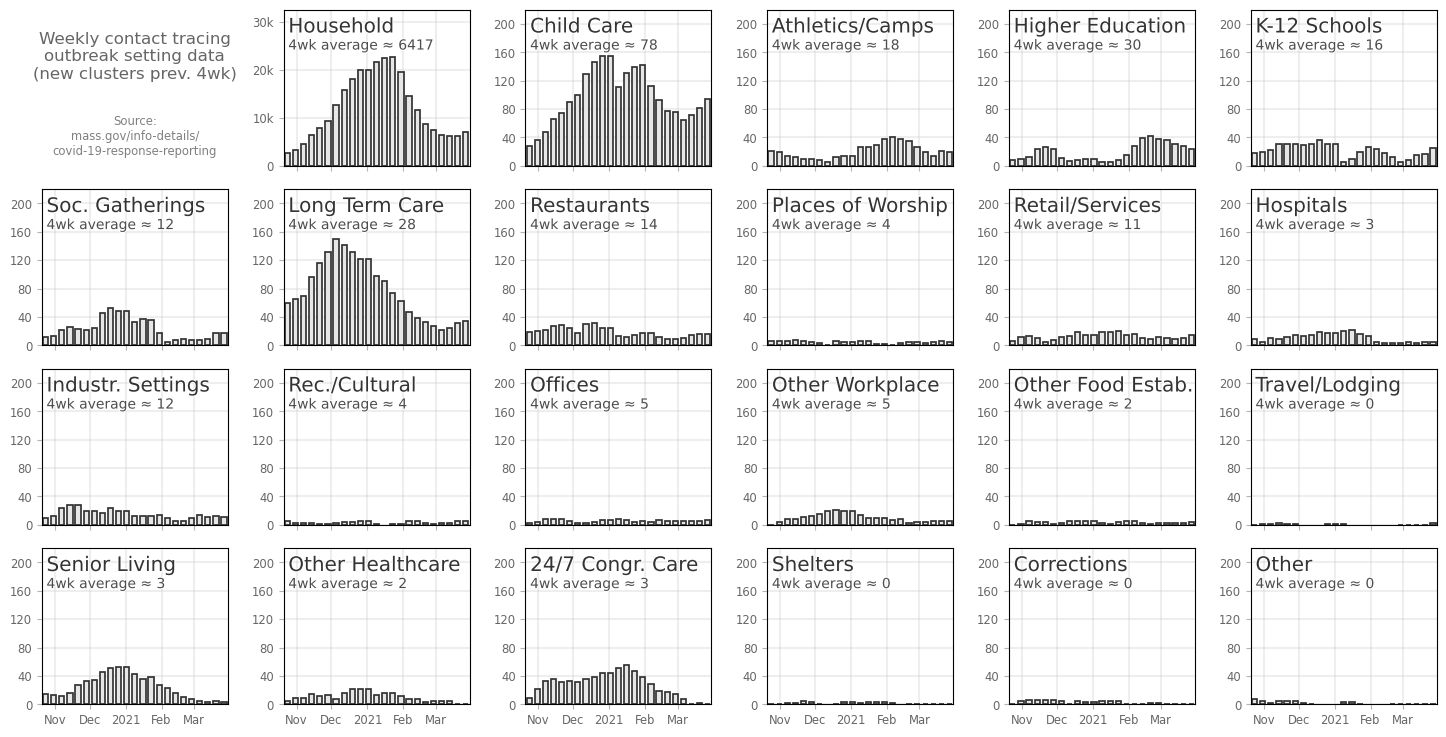

In [18]:
barw = 4.5
w = 3.0; h = 2.3
ncols = 6; nrows = 4
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True)
plt.subplots_adjust(wspace=0.3,hspace=0.15)

labs = dict(zip(contact_df['setting'].unique(),['24/7 Congr. Care', 'Child Care',
       'Higher Education', 'Corrections', 'Hospitals', 'Household',
       'Industr. Settings', 'K-12 Schools', 'Long Term Care',
       'Offices', 'Athletics/Camps', 'Other',
       'Other Food Estab.', 'Other Healthcare',
       'Other Workplace', 'Places of Worship', 'Rec./Cultural',
       'Restaurants', 'Retail/Services', 'Senior Living',
       'Shelters', 'Soc. Gatherings', 'Travel/Lodging']))

ncats = contact_df['setting'].nunique()
dates_tt = ['2020-11-01','2020-12-01','2021-01-01','2021-02-01','2021-03-01']
dates_ll = ['Nov','Dec','2021','Feb','Mar']
settings_order = contact_df.loc[contact_df['end_date']==contact_df['end_date'].max()\
                   ].sort_values('raw_new_cases',ascending=False)['setting'].unique()

for di, dcurr in enumerate(settings_order):
    di += 1
    aa = ax[tups[di]]
    cti = contact_df.loc[contact_df['setting']==dcurr].copy()
    aa.bar([date_dict[i] for i in cti['end_date']], cti['raw_new_clusters'],
           fc='.9', ec='.2', width=barw, lw=1.25)
    
    aa.text(0.025,0.95,labs[dcurr],ha='left',va='top',
            transform=aa.transAxes,fontsize='x-large',color='.2',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),
                          path_effects.Normal()])

    four_wmean = np.nanmean(np.nan_to_num(cti['raw_new_clusters'].values)[-4:])
    aa.text(0.025,0.815,'4wk average ≈ %i'%(four_wmean),
            ha='left', va='top',transform=aa.transAxes, fontsize='medium',color='.3',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),
                          path_effects.Normal()])

    aa.grid(linewidth=1.5,color='.75',alpha=0.25)
    aa.tick_params(labelcolor='.4',color='.7',labelsize='small')

    aa.set_xticks([date_dict[i] for i in dates_tt])
    aa.set_xticklabels(dates_ll)
    aa.set_xlim(date_dict[contact_df['end_date'].min()]-barw/2-1,
                date_dict[contact_df['end_date'].max()]+barw/2+1)

    aa.yaxis.set_major_locator(MaxNLocator(integer=True, nbins='auto'))
    ylims = aa.get_ylim()
    ydiff = ylims[1] - ylims[0]
    aa.set_ylim(ylims[0], ylims[1]+ydiff*0.35)

    if labs[dcurr]=='Household':
        aa.set_ylim(0, 32500)
        aa.set_yticks([0, 10000, 20000, 30000])
        aa.set_yticklabels(['0', '10k', '20k', '30k'])
    else:
        aa.set_ylim(0, 220)



aa = ax[tups[0]]
aa.text(0.5, 0.70, 'Weekly contact tracing\noutbreak setting data\n(new clusters prev. 4wk)',
        ha='center', va='center', transform=aa.transAxes, color='.4', fontsize='large')
aa.text(0.5, 0.05, 'Source:\nmass.gov/info-details/\ncovid-19-response-reporting',
        ha='center', va='bottom', transform=aa.transAxes, color='.5', fontsize='small')

aa.set_axis_off()

plt.savefig('../figs/pngs/ma_outbreak_settings_newclusters_all.png',dpi=425,bbox_inches='tight')
plt.savefig('../figs/pdfs/ma_outbreak_settings_newclusters_all.pdf',bbox_inches='tight')

plt.show()

In [19]:
contact_df

data_date  start_date    end_date                   setting  \
0    2020-10-29  2020-09-27  2020-10-24  24/7 Congregate Settings   
1    2020-11-06  2020-10-04  2020-10-31  24/7 Congregate Settings   
2    2020-11-12  2020-10-11  2020-11-07  24/7 Congregate Settings   
3    2020-11-19  2020-10-18  2020-11-14  24/7 Congregate Settings   
4    2020-11-27  2020-10-25  2020-11-21  24/7 Congregate Settings   
..          ...         ...         ...                       ...   
524  2021-03-04  2021-01-31  2021-02-27          Travel & Lodging   
525  2021-03-11  2021-02-07  2021-03-06          Travel & Lodging   
526  2021-03-18  2021-02-14  2021-03-13          Travel & Lodging   
527  2021-03-25  2021-02-21  2021-03-20          Travel & Lodging   
528  2021-04-01  2021-02-28  2021-03-27          Travel & Lodging   

     raw_new_clusters  raw_new_cases  raw_new_contacts  raw_total_clusters  \
0                 9.0           41.0               9.0                17.0   
1                21.0           75.0              43.0                30.0   
2                33.0          124.0              59.0                45.0   
3                35.0          136.0              66.0                53.0   
4                32.0          127.0              24.0                66.0   
..                ...            ...               ...                 ...   
524               0.0            0.0               0.0                 0.0   
525               0.0            0.0               0.0                 0.0   
526               0.0            0.0               0.0                 0.0   
527               0.0            0.0               0.0                 0.0   
528               2.0           11.0               5.0                 2.0   

     raw_total_cases  raw_total_contacts  
0               59.0                16.0  
1              107.0                56.0  
2              159.0                 NaN  
3              190.0                 NaN  
4              193.0                 NaN  
..               ...                 ...  
524              0.0                 0.0  
525              0.0                 0.0  
526              0.0                 0.0  
527              0.0                 0.0  
528             11.0                 5.0  

[529 rows x 10 columns]

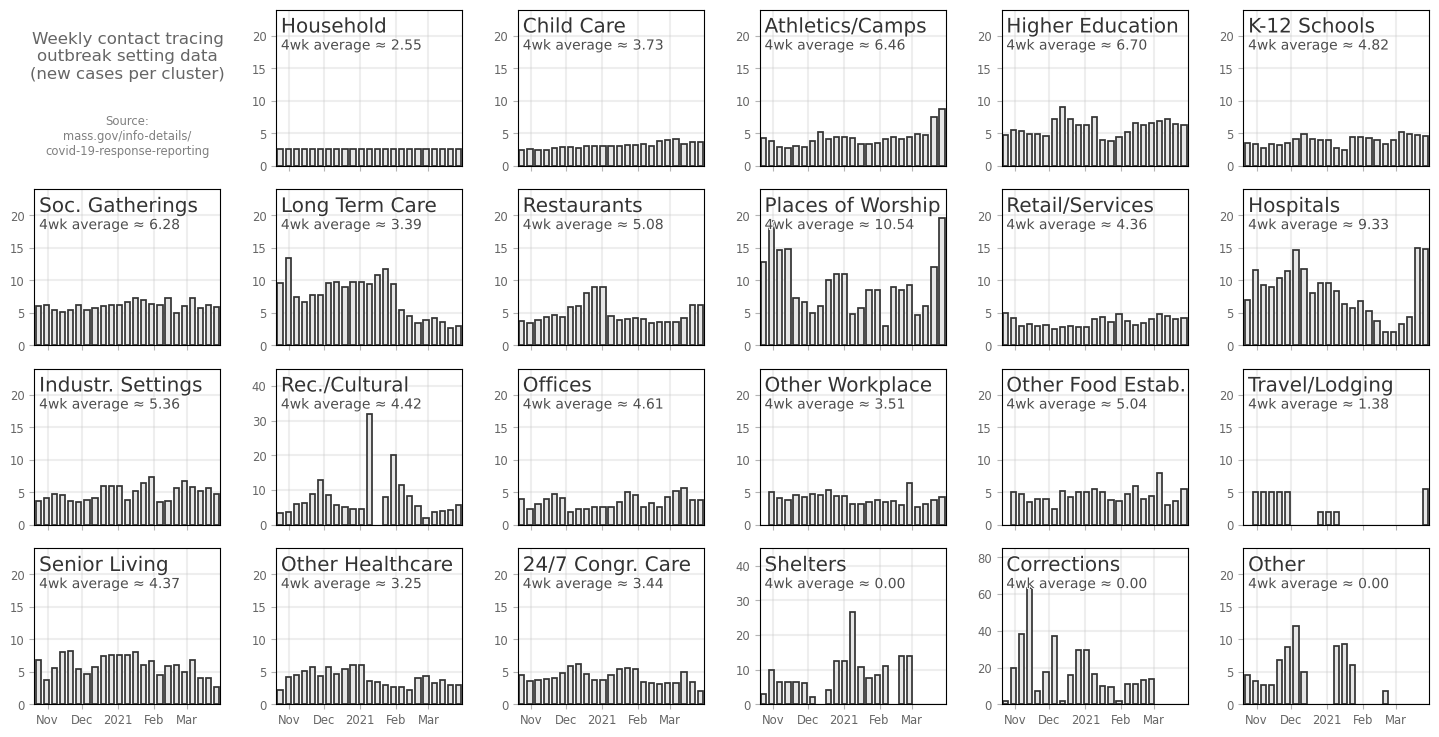

In [20]:
barw = 4.5
w = 3.0; h = 2.3
ncols = 6; nrows = 4
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True)
plt.subplots_adjust(wspace=0.3,hspace=0.15)

labs = dict(zip(contact_df['setting'].unique(),['24/7 Congr. Care', 'Child Care',
       'Higher Education', 'Corrections', 'Hospitals', 'Household',
       'Industr. Settings', 'K-12 Schools', 'Long Term Care',
       'Offices', 'Athletics/Camps', 'Other',
       'Other Food Estab.', 'Other Healthcare',
       'Other Workplace', 'Places of Worship', 'Rec./Cultural',
       'Restaurants', 'Retail/Services', 'Senior Living',
       'Shelters', 'Soc. Gatherings', 'Travel/Lodging']))

ncats = contact_df['setting'].nunique()
dates_tt = ['2020-11-01','2020-12-01','2021-01-01','2021-02-01','2021-03-01']
dates_ll = ['Nov','Dec','2021','Feb','Mar']
settings_order = contact_df.loc[contact_df['end_date']==contact_df['end_date'].max()\
                   ].sort_values('raw_new_cases',ascending=False)['setting'].unique()

for di, dcurr in enumerate(settings_order):
    di += 1
    aa = ax[tups[di]]
    cti = contact_df.loc[contact_df['setting']==dcurr].copy()
    cti['raw_new_cases_per'] = cti['raw_new_cases']/cti['raw_new_clusters']
    aa.bar([date_dict[i] for i in cti['end_date']], cti['raw_new_cases_per'],
           fc='.9', ec='.2', width=barw, lw=1.25)
    
    aa.text(0.025,0.95,labs[dcurr],ha='left',va='top',
            transform=aa.transAxes,fontsize='x-large',color='.2',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),
                          path_effects.Normal()])
    aa.grid(linewidth=1.5,color='.75',alpha=0.25)
    aa.tick_params(labelcolor='.4',color='.7',labelsize='small')

    aa.set_xticks([date_dict[i] for i in dates_tt])
    aa.set_xticklabels(dates_ll)
    aa.set_xlim(date_dict[contact_df['end_date'].min()]-barw/2-1,
                date_dict[contact_df['end_date'].max()]+barw/2+1)

    four_wmean = np.nanmean(np.nan_to_num(cti['raw_new_cases_per'].values)[-4:])
    aa.text(0.025,0.815,'4wk average ≈ %.2f'%(four_wmean),
            ha='left', va='top',transform=aa.transAxes, fontsize='medium',color='.3',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'),
                          path_effects.Normal()])
    if labs[dcurr]=='Corrections':
        aa.set_ylim(0, 85)
    elif labs[dcurr] in ['Rec./Cultural','Shelters']:
        aa.set_ylim(0, 45)
    else:
        aa.set_ylim(0, 24)

aa = ax[tups[0]]
aa.text(0.5, 0.70, 'Weekly contact tracing\noutbreak setting data\n(new cases per cluster)',
        ha='center', va='center', transform=aa.transAxes, color='.4', fontsize='large')
aa.text(0.5, 0.05, 'Source:\nmass.gov/info-details/\ncovid-19-response-reporting',
        ha='center', va='bottom', transform=aa.transAxes, color='.5', fontsize='small')
aa.set_axis_off()

plt.savefig('../figs/pngs/ma_outbreak_settings_newcases_per_all.png',dpi=425,bbox_inches='tight')
plt.savefig('../figs/pdfs/ma_outbreak_settings_newcases_per_all.pdf',bbox_inches='tight')

plt.show()

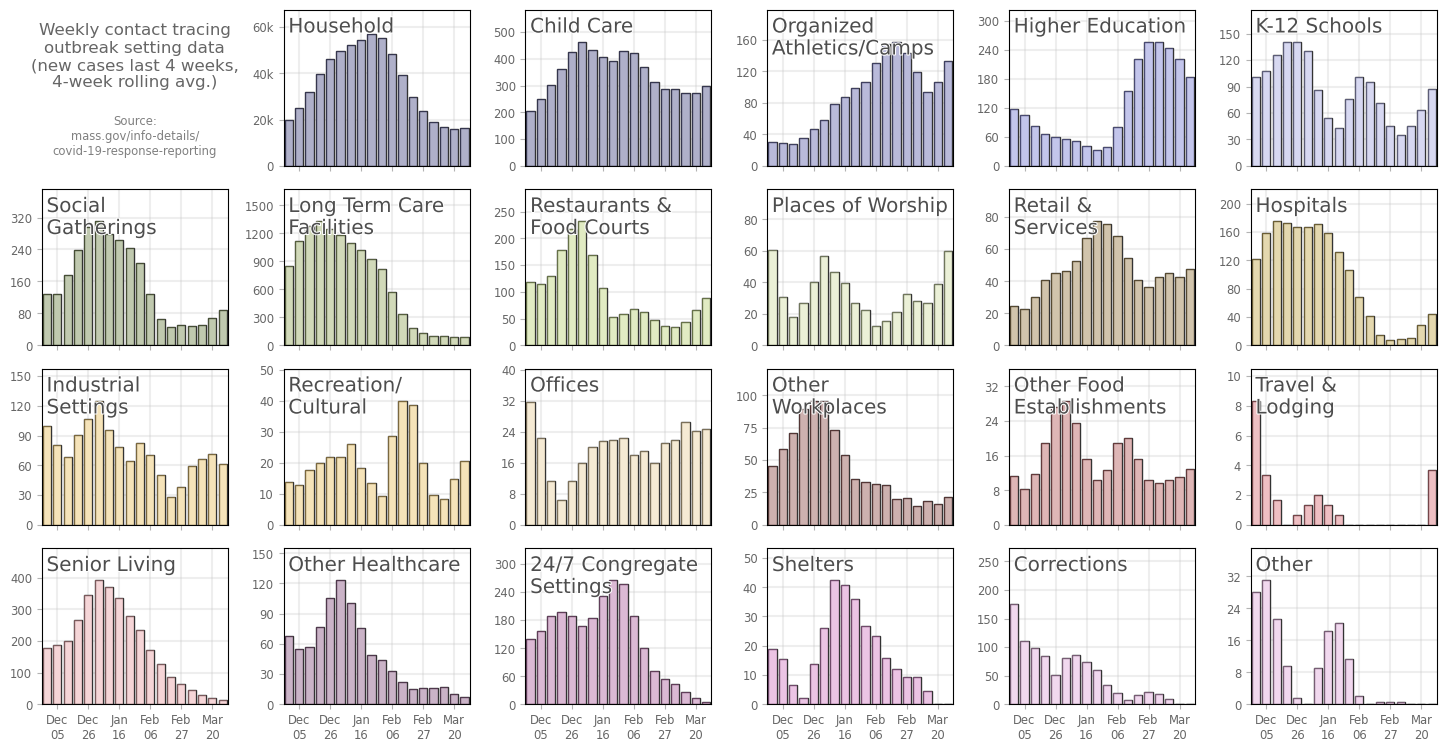

In [21]:
w = 3.0; h = 2.3
ncols = 6; nrows = 4
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True)#, sharey=True)
plt.subplots_adjust(wspace=0.3,hspace=0.15)

labs = dict(zip(contact_df['setting'].unique(),['24/7 Congregate\nSettings', 'Child Care',
       'Higher Education', 'Corrections', 'Hospitals', 'Household',
       'Industrial\nSettings', 'K-12 Schools', 'Long Term Care\nFacilities',
       'Offices', 'Organized\nAthletics/Camps', 'Other',
       'Other Food\nEstablishments', 'Other Healthcare',
       'Other\nWorkplaces', 'Places of Worship', 'Recreation/\nCultural',
       'Restaurants &\nFood Courts', 'Retail &\nServices', 'Senior Living',
       'Shelters', 'Social\nGatherings', 'Travel &\nLodging']))

ncats = contact_df['setting'].nunique()
cols = plt.cm.tab20b(np.linspace(0,1,ncats))

for di, dcurr in enumerate(contact_df.loc[contact_df['end_date']==contact_df['end_date'].max()\
                           ].sort_values('raw_new_cases',ascending=False)['setting'].unique()):
    di += 1
    aa = ax[tups[di]]
    cti = contact_df.loc[contact_df['setting']==dcurr].copy()
    cti.loc[cti['raw_new_cases']=='','raw_new_cases'] = 0
    cti.loc[cti['raw_new_cases'].isna(),'raw_new_cases'] = 0
    cti['raw_new_cases'] = cti['raw_new_cases'].rolling(window=3).mean()
    aa.bar(list(range(len(cti['raw_new_cases'])-4)),cti['raw_new_cases'].values[4:],fc='w',ec='.2')
    aa.bar(list(range(len(cti['raw_new_cases'])-4)),cti['raw_new_cases'].values[4:],fc=cols[di-1],
           ec='none',alpha=0.4)
    
    aa.text(0.025,0.95,labs[dcurr],ha='left',va='top',transform=aa.transAxes,fontsize='x-large',color='.3',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'), path_effects.Normal()])
    aa.grid(linewidth=1.5,color='.75',alpha=0.25)
    aa.tick_params(labelcolor='.4',color='.7',labelsize='small')
    aa.set_xticks([i for i in list(range(contact_df['end_date'].nunique()-4))[2::3]])
    aa.set_xticklabels([month_dict[i[5:7]]+"\n%s"%i[8:] for i in contact_df['end_date'].unique()[6::3]])
    xlimx = max(list(range(len(cti['raw_new_cases']))))-3.5
    aa.set_xlim(0.5,xlimx)
    aa.yaxis.set_major_locator(MaxNLocator(integer=True, nbins='auto'))
    ylims = aa.get_ylim()
    ydiff = ylims[1] - ylims[0]
    aa.set_ylim(ylims[0], ylims[1]+ydiff*0.2)

    if di == 1:
        aa.set_ylim(0, 67500)
        aa.set_yticks([0, 20000, 40000, 60000])
        aa.set_yticklabels(['0', '20k', '40k', '60k'])



aa = ax[tups[0]]
aa.text(0.5, 0.70, 'Weekly contact tracing\noutbreak setting data\n(new cases last 4 weeks,\n4-week rolling avg.)',
        ha='center', va='center', transform=aa.transAxes, color='.4', fontsize='large')
aa.text(0.5, 0.05, 'Source:\nmass.gov/info-details/\ncovid-19-response-reporting',
        ha='center', va='bottom', transform=aa.transAxes, color='.5', fontsize='small')

aa.set_axis_off()

plt.savefig('../figs/pngs/ma_outbreak_settings_newcases.png',dpi=425,bbox_inches='tight')

plt.show()

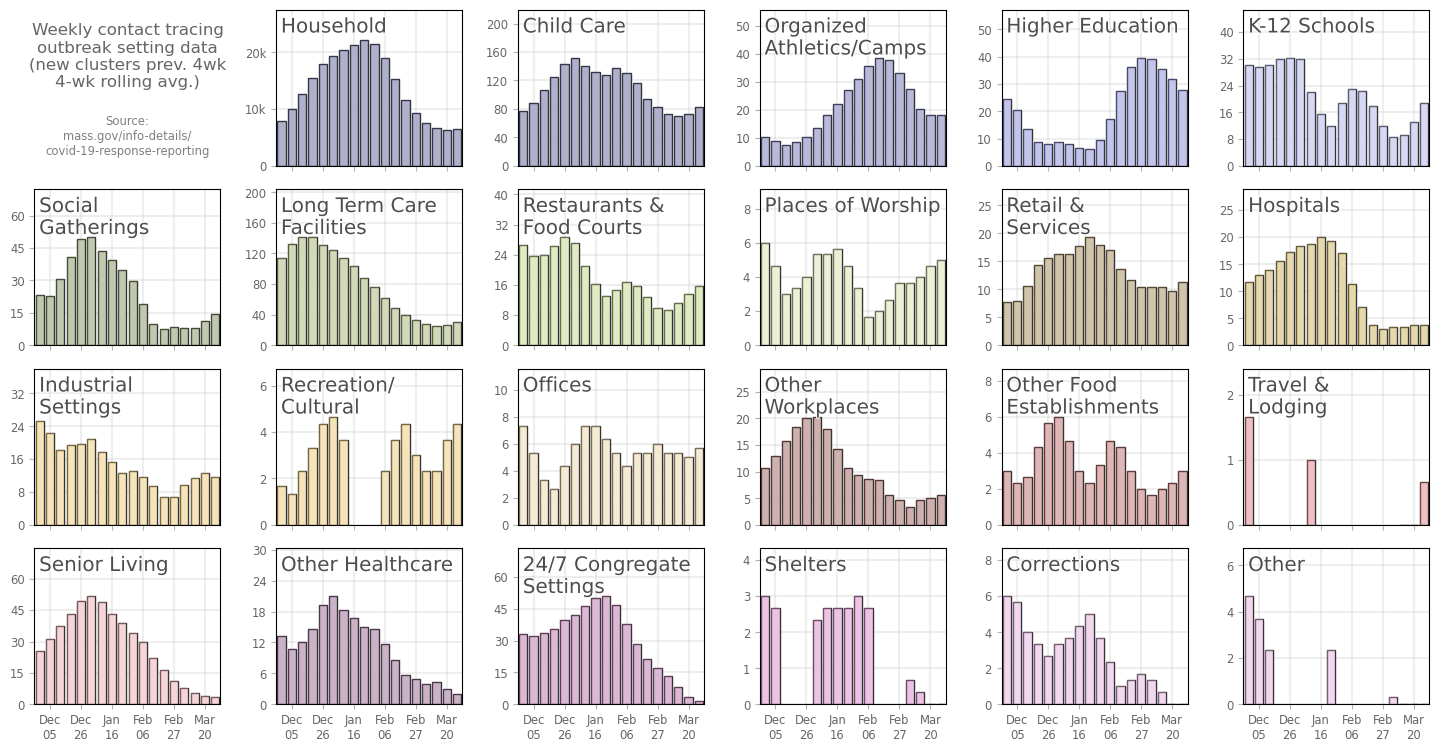

In [22]:
w = 3.0; h = 2.3
ncols = 6; nrows = 4
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True)#, sharey=True)
plt.subplots_adjust(wspace=0.3,hspace=0.15)

labs = dict(zip(contact_df['setting'].unique(),['24/7 Congregate\nSettings', 'Child Care',
       'Higher Education', 'Corrections', 'Hospitals', 'Household',
       'Industrial\nSettings', 'K-12 Schools', 'Long Term Care\nFacilities',
       'Offices', 'Organized\nAthletics/Camps', 'Other',
       'Other Food\nEstablishments', 'Other Healthcare',
       'Other\nWorkplaces', 'Places of Worship', 'Recreation/\nCultural',
       'Restaurants &\nFood Courts', 'Retail &\nServices', 'Senior Living',
       'Shelters', 'Social\nGatherings', 'Travel &\nLodging']))

ncats = contact_df['setting'].nunique()
cols = plt.cm.tab20b(np.linspace(0,1,ncats))

for di, dcurr in enumerate(contact_df.loc[contact_df['end_date']==contact_df['end_date'].max()\
                           ].sort_values('raw_new_cases',ascending=False)['setting'].unique()):
    di += 1
    aa = ax[tups[di]]
    cti = contact_df.loc[contact_df['setting']==dcurr].copy()
    cti.loc[cti['raw_new_clusters']=='','raw_new_clusters'] = 0
    cti['raw_new_clusters'] = cti['raw_new_clusters'].rolling(window=3).mean()
    aa.bar(list(range(len(cti['raw_new_clusters']))),cti['raw_new_clusters'].values,fc='w',ec='.2')
    aa.bar(list(range(len(cti['raw_new_clusters']))),cti['raw_new_clusters'].values,fc=cols[di-1],
           ec='none',alpha=0.4)
    
    aa.text(0.025,0.95,labs[dcurr],ha='left',va='top',transform=aa.transAxes,fontsize='x-large',color='.3',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'), path_effects.Normal()])
    aa.grid(linewidth=1.5,color='.75',alpha=0.25)
    aa.tick_params(labelcolor='.4',color='.7',labelsize='small')
    aa.set_xticks([i for i in list(range(contact_df['end_date'].nunique()))[::3]])
    aa.set_xticklabels([month_dict[i[5:7]]+"\n%s"%i[8:] for i in contact_df['end_date'].unique()[::3]])
    xlimx = max(list(range(len(cti['raw_new_cases']))))+0.5
    aa.set_xlim(4.5,xlimx)
    aa.yaxis.set_major_locator(MaxNLocator(integer=True, nbins='auto'))
    ylims = aa.get_ylim()
    ydiff = ylims[1] - ylims[0]
    aa.set_ylim(ylims[0], ylims[1]+ydiff*0.375)

    if di == 1:
        aa.set_ylim(0, 27500)
        aa.set_yticks([0, 10000, 20000])
        aa.set_yticklabels(['0', '10k', '20k'])



aa = ax[tups[0]]
aa.text(0.5, 0.70, 'Weekly contact tracing\noutbreak setting data\n(new clusters prev. 4wk\n4-wk rolling avg.)',
        ha='center', va='center', transform=aa.transAxes, color='.4', fontsize='large')
aa.text(0.5, 0.05, 'Source:\nmass.gov/info-details/\ncovid-19-response-reporting',
        ha='center', va='bottom', transform=aa.transAxes, color='.5', fontsize='small')

# aa.text(0.5, 0.6, 'Weekly contact\ntracing setting\ndata (new clusters\nprev. 4 weeks)',
#         ha='center', va='center', transform=aa.transAxes, color='.4', fontsize='large')

aa.set_axis_off()


plt.savefig('../figs/pngs/ma_outbreak_settings_newclusters.png',dpi=425,bbox_inches='tight')

plt.show()

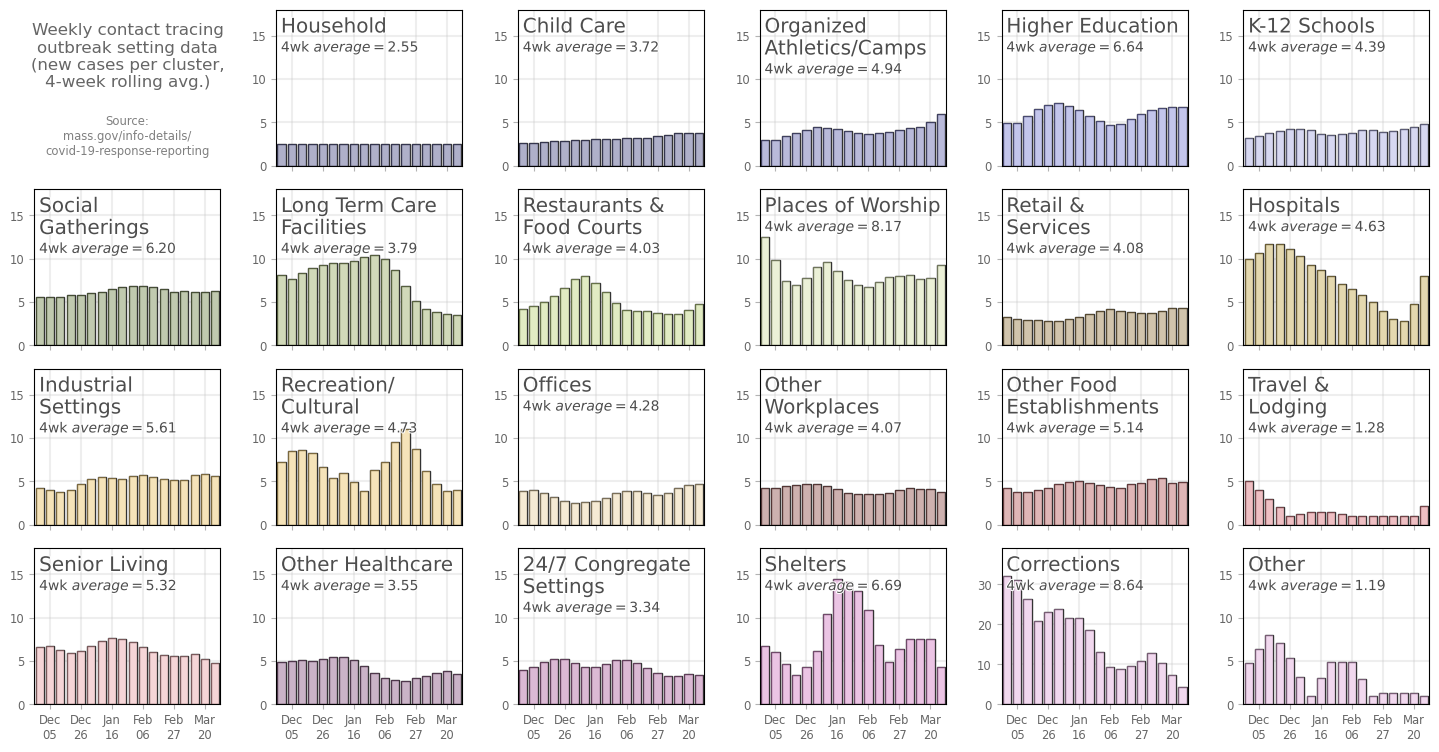

In [23]:
w = 3.0; h = 2.3
ncols = 6; nrows = 4
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True)#, sharey=True)
plt.subplots_adjust(wspace=0.3,hspace=0.15)

labs = dict(zip(contact_df['setting'].unique(),['24/7 Congregate\nSettings', 'Child Care',
       'Higher Education', 'Corrections', 'Hospitals', 'Household',
       'Industrial\nSettings', 'K-12 Schools', 'Long Term Care\nFacilities',
       'Offices', 'Organized\nAthletics/Camps', 'Other',
       'Other Food\nEstablishments', 'Other Healthcare',
       'Other\nWorkplaces', 'Places of Worship', 'Recreation/\nCultural',
       'Restaurants &\nFood Courts', 'Retail &\nServices', 'Senior Living',
       'Shelters', 'Social\nGatherings', 'Travel &\nLodging']))

ncats = contact_df['setting'].nunique()
cols = plt.cm.tab20b(np.linspace(0,1,ncats))

for di, dcurr in enumerate(contact_df.loc[contact_df['end_date']==contact_df['end_date'].max()\
                           ].sort_values('raw_new_cases',ascending=False)['setting'].unique()):
    di += 1
    aa = ax[tups[di]]
    cti = contact_df.loc[contact_df['setting']==dcurr].copy()
    cti.loc[cti['raw_new_clusters']=='','raw_new_clusters'] = 0
    cti.loc[cti['raw_new_cases']=='','raw_new_cases'] = 0
    cti['raw_new_cases'] = np.nan_to_num(cti['raw_new_cases'].rolling(window=2).mean())+1e-8
    cti['raw_new_clusters'] = np.nan_to_num(cti['raw_new_clusters'].rolling(window=2).mean())+1e-8
#     cti['raw_new_cases_per'] = cti['raw_new_cases'] / cti['raw_new_clusters']
    cti['raw_new_cases_per'] = np.nan_to_num(cti['raw_new_cases']) / np.nan_to_num(cti['raw_new_clusters'])
    cti['raw_new_cases_per'] = np.nan_to_num(cti['raw_new_cases_per'].rolling(window=4).mean())
#     cti['raw_new_cases_per'] = cti['raw_new_cases'] / cti['raw_new_clusters'].rolling(window=2).mean()
    aa.bar(list(range(len(cti['raw_new_cases']))),cti['raw_new_cases_per'].values,fc='w',ec='.2')
    aa.bar(list(range(len(cti['raw_new_cases']))),cti['raw_new_cases_per'].values,fc=cols[di-1],
           ec='none',alpha=0.4)

    aa.text(0.025,0.95,labs[dcurr],
            ha='left', va='top',transform=aa.transAxes, fontsize='x-large',color='.3',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'), path_effects.Normal()])
    ym = 0.815
    if "\n" in labs[dcurr]:
        ym = 0.675
    aa.text(0.025,ym,'4wk $average=%.2f$'%(np.mean(cti['raw_new_cases_per'].dropna().values[-4:])),
#     aa.text(0.025,ym,'$average=%.1f$'%(cti['raw_new_cases_per'].dropna().mean()),
            ha='left', va='top',transform=aa.transAxes, fontsize='medium',color='.3',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'), path_effects.Normal()])

    aa.grid(linewidth=1.5,color='.75',alpha=0.25)
    xlimx = max(list(range(len(cti['raw_new_cases']))))+0.5

    aa.tick_params(labelcolor='.4',color='.7',labelsize='small')
    aa.set_xticks([i for i in list(range(contact_df['end_date'].nunique()))[::3]])
    if labs[dcurr] == 'Corrections':
        aa.set_ylim(0, 39)
    else:
        aa.set_ylim(0, 18)
    aa.set_xticklabels([month_dict[i[5:7]]+"\n%s"%i[8:] for i in contact_df['end_date'].unique()[::3]])
    aa.set_xlim(4.5,xlimx)


aa = ax[tups[0]]
aa.text(0.5, 0.70, 'Weekly contact tracing\noutbreak setting data\n(new cases per cluster,\n4-week rolling avg.)',
        ha='center', va='center', transform=aa.transAxes, color='.4', fontsize='large')
aa.text(0.5, 0.05, 'Source:\nmass.gov/info-details/\ncovid-19-response-reporting',
        ha='center', va='bottom', transform=aa.transAxes, color='.5', fontsize='small')

aa.set_axis_off()

plt.savefig('../figs/pngs/ma_outbreak_settings_newcases_per.png',dpi=425,bbox_inches='tight')

plt.show()

# vulnerable or older populations

In [24]:
temp = contact_df.loc[contact_df['setting'].isin(['Other Healthcare','Hospitals'])].copy()
gbcols = ['data_date', 'start_date', 'end_date']
agcols = ['raw_new_clusters', 'raw_new_cases', 'raw_new_contacts',
          'raw_total_clusters', 'raw_total_cases', 'raw_total_contacts']
temp = temp.groupby(gbcols).agg({i:'sum' for i in agcols}).reset_index()
temp['setting'] = 'Hospitals & Other Healthcare'
temp = temp[gbcols+['setting']+agcols]

In [25]:
contact_dfx = pd.concat([contact_df,temp]).reset_index().iloc[:,1:]

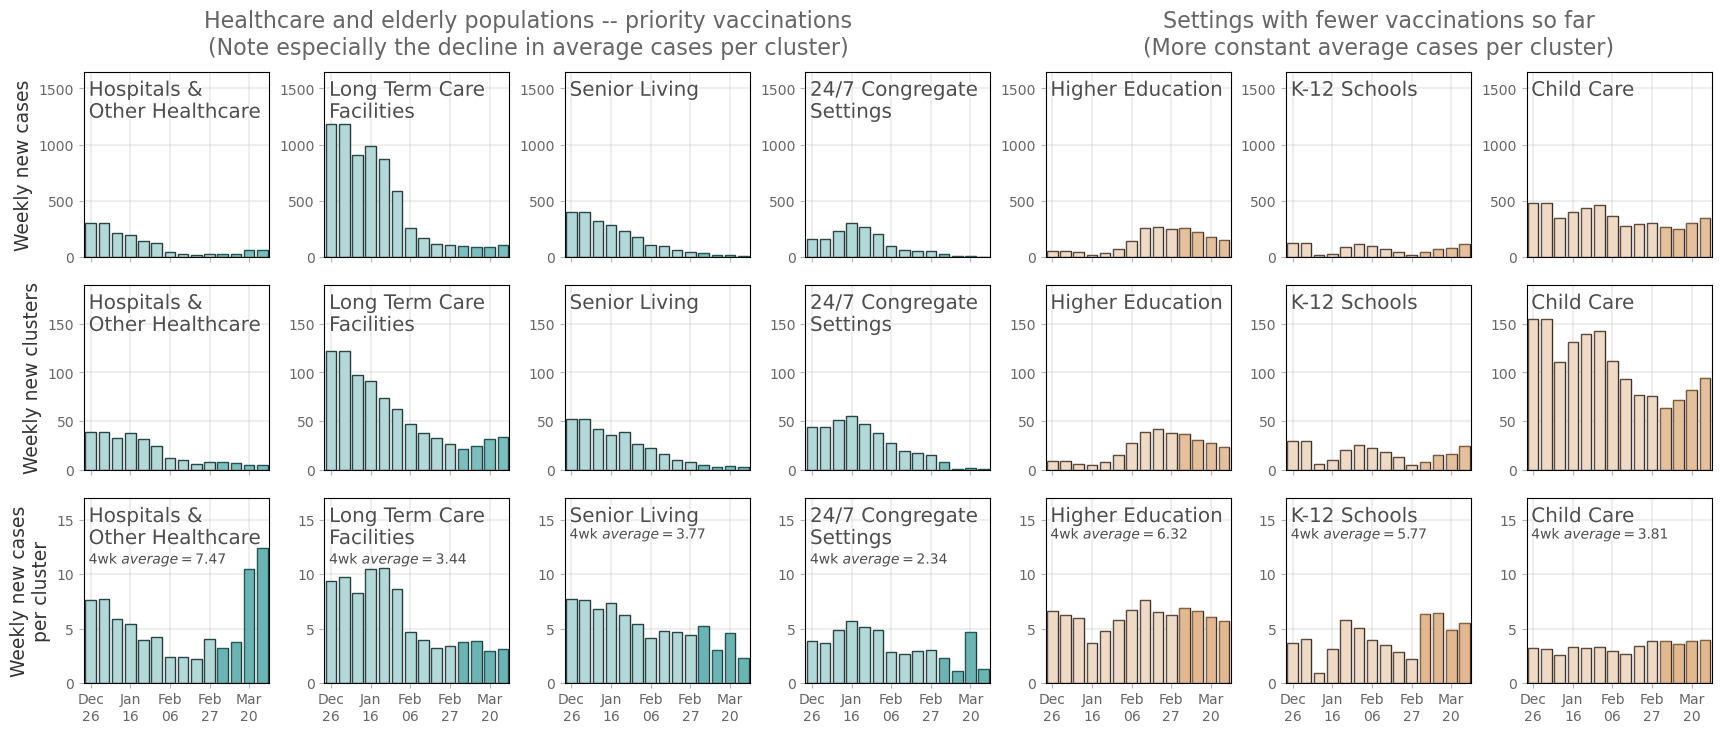

In [26]:
w = 3.0; h = 2.7
ncols = 7; nrows = 3
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100, sharex=True)#, sharey=True)
plt.subplots_adjust(wspace=0.3,hspace=0.15)

labs = dict(zip(contact_df['setting'].unique(),['24/7 Congregate\nSettings', 'Child Care',
       'Higher Education', 'Corrections', 'Hospitals', 'Household',
       'Industrial\nSettings', 'K-12 Schools', 'Long Term Care\nFacilities',
       'Offices', 'Organized\nAthletics/Camps', 'Other',
       'Other Food\nEstablishments', 'Other Healthcare',
       'Other\nWorkplaces', 'Places of Worship', 'Recreation/\nCultural',
       'Restaurants &\nFood Courts', 'Retail &\nServices', 'Senior Living',
       'Shelters', 'Social\nGatherings', 'Travel &\nLodging']))

labs = dict(zip(['Hospitals & Other Healthcare', 'Long Term Care Facilities', 'Senior Living',
                 '24/7 Congregate Settings', 'Colleges & Universities', 'K-12 Schools', 'Child Care'],
                ['Hospitals &\nOther Healthcare', 'Long Term Care\nFacilities', 'Senior Living',
                 '24/7 Congregate\nSettings', 'Higher Education', 'K-12 Schools', 'Child Care']))

ncats = len(labs.keys())
cols = plt.cm.tab20b(np.linspace(0,1,ncats))
cols = ['teal']*4 + ['peru']*3
for di, dcurr in enumerate(list(labs.keys())):
    fci = cols[di]
    aa = ax[tups[di]]
    cti = contact_dfx.loc[contact_dfx['setting']==dcurr].copy()
    cti.loc[cti['raw_new_cases']=='','raw_new_cases'] = 0
    aa.bar(list(range(len(cti['raw_new_cases']))),cti['raw_new_cases'].values,fc='w',ec='.2')
    aa.bar(list(range(len(cti['raw_new_cases']))),cti['raw_new_cases'].values,fc=fci,
           ec='none',alpha=0.3)
    aa.bar(list(range(len(cti['raw_new_cases'])))[-4:],cti['raw_new_cases'].values[-4:],fc=fci,
           ec='none',alpha=0.3)
    
    aa.text(0.025,0.95,labs[dcurr],ha='left',va='top',transform=aa.transAxes,fontsize='x-large',color='.3',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'), path_effects.Normal()])

xlimx = max(list(range(len(cti['raw_new_cases']))))+0.5
dn = di

for di, dcurr in enumerate(list(labs.keys())):
    fci = cols[di]
    di += dn + 1
    aa = ax[tups[di]]
    cti = contact_dfx.loc[contact_dfx['setting']==dcurr].copy()
    aa.bar(list(range(len(cti['raw_new_clusters']))),cti['raw_new_clusters'].values,fc='w',ec='.2')
    aa.bar(list(range(len(cti['raw_new_clusters']))),cti['raw_new_clusters'].values,fc=fci,
           ec='none',alpha=0.3)
    aa.bar(list(range(len(cti['raw_new_clusters'])))[-4:],cti['raw_new_clusters'].values[-4:],fc=fci,
           ec='none',alpha=0.3)
    
    aa.text(0.025,0.95,labs[dcurr],ha='left',va='top',transform=aa.transAxes,fontsize='x-large',color='.3',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'), path_effects.Normal()])
    
dn = di

for di, dcurr in enumerate(list(labs.keys())):
    fci = cols[di]
    di += dn + 1
    aa = ax[tups[di]]
    cti = contact_dfx.loc[contact_dfx['setting']==dcurr].copy()
    cti['raw_new_cases_per'] = cti['raw_new_cases'] / cti['raw_new_clusters'].rolling(window=2).mean()
    aa.bar(list(range(len(cti['raw_new_cases_per']))),cti['raw_new_cases_per'].values,fc='w',ec='.2')
    aa.bar(list(range(len(cti['raw_new_cases_per']))),cti['raw_new_cases_per'].values,fc=fci,
           ec='none',alpha=0.3)
    aa.bar(list(range(len(cti['raw_new_cases_per'])))[-4:],cti['raw_new_cases_per'].values[-4:],fc=fci,
           ec='none',alpha=0.4)

    aa.text(0.025,0.95,labs[dcurr],
            ha='left', va='top',transform=aa.transAxes, fontsize='x-large',color='.3',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'), path_effects.Normal()])
    ym = 0.85
    if "\n" in labs[dcurr]:
        ym = 0.715
    aa.text(0.025,ym,'4wk $average=%.2f$'%(np.mean(cti['raw_new_cases_per'].dropna().values[-4:])),
            ha='left', va='top',transform=aa.transAxes, fontsize='medium',color='.3',
            path_effects=[path_effects.Stroke(linewidth=1.5, foreground='w'), path_effects.Normal()])


for ai, a in enumerate(fig.axes):
    a.set_xticks([i for i in list(range(contact_dfx['end_date'].nunique()))[::3]])
    a.set_xticklabels([month_dict[i[5:7]]+"\n%s"%i[8:] for i in contact_dfx['end_date'].unique()[::3]])
    a.set_xlim(8.5, xlimx)
    a.tick_params(labelcolor='.4',color='.7',labelsize='medium')
    a.grid(linewidth=1.5,color='.75',alpha=0.25)
    ylims = a.get_ylim()
    ydiff = ylims[1] - ylims[0]
    a.set_ylim(ylims[0], ylims[1]+ydiff*0.32)
    if ai < 7:
        a.set_ylim(0, 1650)
    elif ai >= 7 and ai < 14:
        a.set_ylim(0, 190)
    else:
        a.set_ylim(0, 17)


ax[(0,0)].set_ylabel('Weekly new cases', color='.2', fontsize=13.5)
ax[(1,0)].set_ylabel('Weekly new clusters', color='.2', fontsize=13.5)
ax[(2,0)].set_ylabel('Weekly new cases\nper cluster', color='.2', fontsize=13.5)
ax[(0,2)].set_title('Healthcare and elderly populations -- priority vaccinations\n'+\
                    '(Note especially the decline in average cases per cluster)',
                    color='.4', fontsize=16, y=1.05, x=-0.2)
ax[(0,5)].set_title('Settings with fewer vaccinations so far\n(More constant average cases per cluster)',
                    color='.4', fontsize=16, y=1.05)

plt.savefig('../figs/pngs/vaccination_vs_nonvaccination.png',dpi=425,bbox_inches='tight')

plt.show()

# Hospitalization

In [27]:
hosp_fn = 'https://healthdata.gov/api/views/anag-cw7u/rows.csv?accessType=DOWNLOAD'
hosp = pd.read_csv(hosp_fn, dtype={'fips_code':str,'zip':str})
hosp['collection_week'] = hosp.collection_week.astype(str).str[0:4] + '-' +\
                          hosp.collection_week.astype(str).str[5:7] + '-' +\
                          hosp.collection_week.astype(str).str[-2:]
hospx = hosp[['collection_week','state','hospital_name',
              'city','zip','fips_code']].copy()

In [28]:
adult_col = 'total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg'
child_col = 'total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg'
nrep = 500

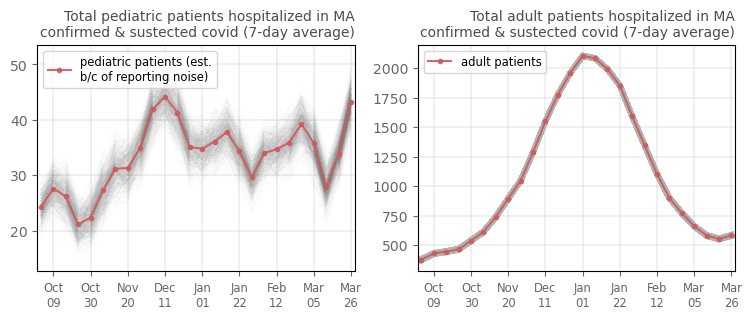

In [29]:
st = 'MA'
fig, ax = plt.subplots(1,2,figsize=(9,3),dpi=100)
adult_avg = []
child_avg = []
wid = 2

for xi in range(nrep):
    ma_hosp = hosp.loc[hosp['state']==st].copy()
    ma_hosp[adult_col] = [i if i != -999999.0 else np.random.randint(1,5) for i in ma_hosp[adult_col]]
    ma_hosp[child_col] = [i if i != -999999.0 else np.random.randint(1,5) for i in ma_hosp[child_col]]

    ma_hosp_g = ma_hosp.groupby(['collection_week']).agg({adult_col:np.nansum,
                                                          child_col:np.nansum}).reset_index()
    dates = [i for i in ma_hosp_g['collection_week'].values if i > '2020-10-01']
    ax[0].plot([date_dict[i] for i in dates],
         ma_hosp_g[child_col].rolling(window=wid).mean().values[-len(dates):],
         color='.5', lw=1, alpha=0.01, marker='')
    ax[1].plot([date_dict[i] for i in dates],
         ma_hosp_g[adult_col].rolling(window=wid).mean().values[-len(dates):],
         color='.7', lw=4, alpha=0.01, marker='')
    adult_avg.append(ma_hosp_g[adult_col].rolling(window=wid).mean().values[-len(dates):])
    child_avg.append(ma_hosp_g[child_col].rolling(window=wid).mean().values[-len(dates):])

ax[0].plot([date_dict[i] for i in dates], np.mean(child_avg,axis=0),
     color='indianred', lw=1.5, alpha=0.9, label='pediatric patients (est.\nb/c of reporting noise)',marker='.')
ax[1].plot([date_dict[i] for i in dates], np.mean(adult_avg,axis=0),
     color='indianred', lw=1.5, alpha=0.9, label='adult patients',marker='.')
        
ax[0].set_title('Total pediatric patients hospitalized in %s'%st+\
                '\nconfirmed & sustected covid (7-day average)',
             x=1,color='.3',ha='right',fontsize='medium')
ax[1].set_title('Total adult patients hospitalized in %s'%st+\
                '\nconfirmed & sustected covid (7-day average)',
             x=1,color='.3',ha='right',fontsize='medium')

for a in fig.axes:
    a.legend(loc=2, fontsize='small')
    a.set_xticks([date_dict[i] for i in dates[1::3]])
    a.set_xticklabels([month_dict[i[5:7]]+"\n%s"%i[8:] for i in dates[1::3]], fontsize='small')
    a.set_xlim(date_dict['2020-10-01']-1,
               date_dict[ma_hosp_g['collection_week'].values[-1]]+2)
    a.tick_params(labelcolor='.4', color='.4')
    a.grid(linewidth=1.25,color='.75',alpha=0.25)

plt.savefig('../figs/pngs/pediatric_and_adult_%s.png'%st,dpi=425,bbox_inches='tight')
plt.show()    

In [30]:
ma_hosp = hosp.loc[hosp['state']==st].copy()
ma_hosp[child_col] = [i if i != -999999.0 else 1 for i in ma_hosp[child_col]]
ma_hosp_g = ma_hosp.groupby(['collection_week']).agg({adult_col:np.nansum,
                                                      child_col:np.nansum}).reset_index()

url_st_hosp = 'https://healthdata.gov/api/views/g62h-syeh/rows.csv?accessType=DOWNLOAD'
hosp_st = pd.read_csv(url_st_hosp)
hosp_st['date'] = pd.to_datetime(hosp_st['date']).astype(str)
hosp_st = hosp_st.loc[hosp_st['date']>'2020-07-15'].copy()
hosp_st = hosp_st.sort_values(['state','date']).reset_index().iloc[:,1:]

all_prev_cols = ['previous_day_admission_adult_covid_confirmed',
                 'previous_day_admission_adult_covid_suspected',
                 'previous_day_admission_pediatric_covid_confirmed',
                 'previous_day_admission_pediatric_covid_suspected']
adult_prev_cols = ['previous_day_admission_adult_covid_confirmed',
                   'previous_day_admission_adult_covid_suspected']
child_prev_cols = ['previous_day_admission_pediatric_covid_confirmed',
                   'previous_day_admission_pediatric_covid_suspected']
adult_total_cols = 'total_adult_patients_hospitalized_confirmed_and_suspected_covid'
child_total_cols = 'total_pediatric_patients_hospitalized_confirmed_and_suspected_covid'
total_cols = ['total_adult_patients_hospitalized_confirmed_and_suspected_covid',
              'total_pediatric_patients_hospitalized_confirmed_and_suspected_covid']

hosp_st['previous_day_admission_confirmed_and_suspected'] = hosp_st[all_prev_cols].sum(axis=1)
hosp_st['total_patients_confirmed_and_suspected_covid'] = hosp_st[total_cols].sum(axis=1)
hosp_st['previous_day_pediatric_admission_confirmed_and_suspected'] = hosp_st[child_prev_cols].sum(axis=1)
hosp_st['previous_day_adult_admission_confirmed_and_suspected'] = hosp_st[adult_prev_cols].sum(axis=1)
ma_hosp = hosp_st.loc[hosp_st['state']=='MA'].copy()
ma_hosp = ma_hosp.loc[ma_hosp['date']>'2020-09-01'].copy()

In [31]:
sch_dfg = school_df.groupby('date').agg({'new_cases_students':'sum',
                                         'new_cases_employee':'sum'}).reset_index()
sch_dfg = sch_dfg.merge(DATE_DF[['date','week']], how='left', on='date')

sch_dfg = pd.concat([sch_dfg,pd.DataFrame({'date':['2020-12-31'],'new_cases_students':[np.nan],
              'new_cases_employee':[np.nan],'week':[51]})]).sort_values('date').reset_index().iloc[:,1:]
sch_dfg.loc[sch_dfg['date']=='2021-02-18','new_cases_students'] = np.nan
sch_dfg.loc[sch_dfg['date']=='2021-02-18','new_cases_employee'] = np.nan

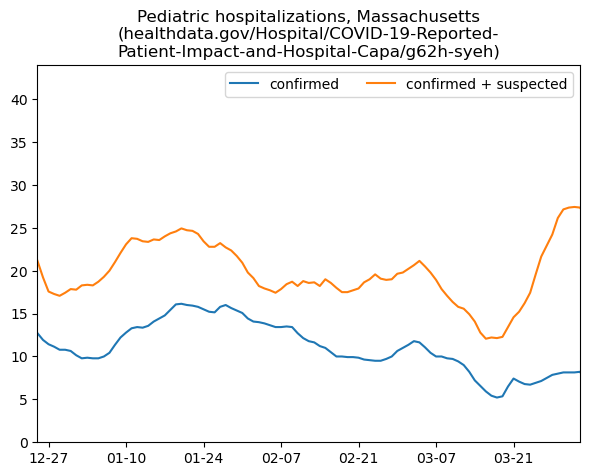

In [32]:
wx = 14
fig, ax = plt.subplots(1,1,figsize=(7,5),dpi=100)

ax.plot([date_dict[i] for i in ma_hosp['date']],
        ma_hosp['total_pediatric_patients_hospitalized_confirmed_covid'].rolling(window=wx).mean(),label='confirmed')
ax.plot([date_dict[i] for i in ma_hosp['date']], 
        ma_hosp['total_pediatric_patients_hospitalized_confirmed_and_suspected_covid'].rolling(window=wx).mean(),label='confirmed + suspected')
ax.legend(ncol=2)
ax.set_xticks([date_dict[i] for i in ma_hosp['date'].values[4::14]])
ax.set_xticklabels([i[5:] for i in ma_hosp['date'].values[4::14]])
ax.set_xlim(date_dict['2020-12-25'], date_dict[today]-2)
ax.set_ylim(0, 44)
ax.set_title('Pediatric hospitalizations, Massachusetts\n(healthdata.gov/Hospital/COVID-19-Reported-\nPatient-Impact-and-Hospital-Capa/g62h-syeh)')

# plt.savefig('../figs/pngs/ma_ped_hosp.png',dpi=300)
plt.show()

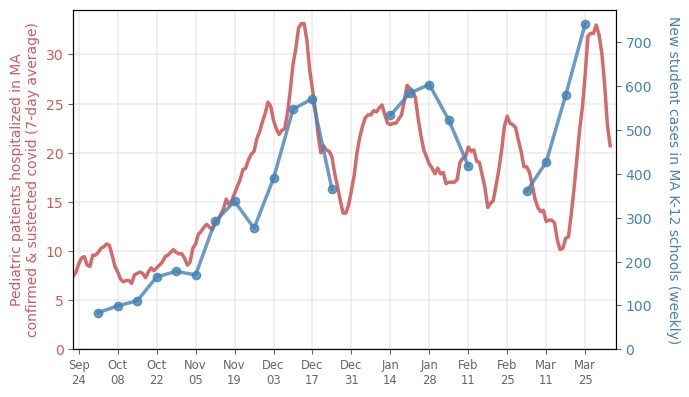

In [33]:
wx = 7
fig, ax = plt.subplots(1,1,figsize=(7,4.5),dpi=100)

ax.plot([date_dict[i] for i in ma_hosp['date']], 
        ma_hosp[child_total_cols].rolling(window=wx).mean(),
         color='indianred', lw=2.5, alpha=0.9, zorder=20)

ax2 = ax.twinx()
ax2.plot([date_dict[i] for i in sch_dfg['date']],
        sch_dfg['new_cases_students'].rolling(window=2).mean(), marker='o',
        label='students', lw=2.5, color='steelblue', zorder=10, alpha=0.8)
ax2.tick_params(axis='x', labelcolor='.4', color='.4')
ax2.tick_params(axis='y', labelcolor='steelblue', color='.4')
ax2.set_ylabel('New student cases in MA K-12 schools (weekly)',
               color='steelblue', rotation=270, labelpad=20)

ax.set_ylabel('Pediatric patients hospitalized in MA'+\
              '\nconfirmed & sustected covid (7-day average)',
              color='indianred')

ax.set_xticks([date_dict[i] for i in sch_dfg['date'].values[::2]])

ax.set_xticklabels([month_dict[i[5:7]]+"\n%s"%i[8:] for i in sch_dfg['date'].values[::2]],
                   fontsize='small')
ax.set_xlim(date_dict['2020-09-21']+wid-1,
            date_dict[ma_hosp['date'].values[-1]]+2)
ax.tick_params(axis='x', labelcolor='.4', color='.4')
ax.tick_params(axis='y', labelcolor='indianred', color='.4')
ax.grid(linewidth=1.25,color='.75',alpha=0.25)
ax.set_ylim(0)
ax2.set_ylim(0)

plt.savefig('../figs/pngs/pediatric_hosp_ma_schools.png',dpi=425,bbox_inches='tight')
plt.show()    

_________________

# Schools

In [34]:
city_dfg = city_df.groupby('date').agg({'new_cases_town':'sum'}).reset_index()
city_dfg = city_dfg.loc[(city_dfg['date']>=sch_dfg['date'].min())].copy()

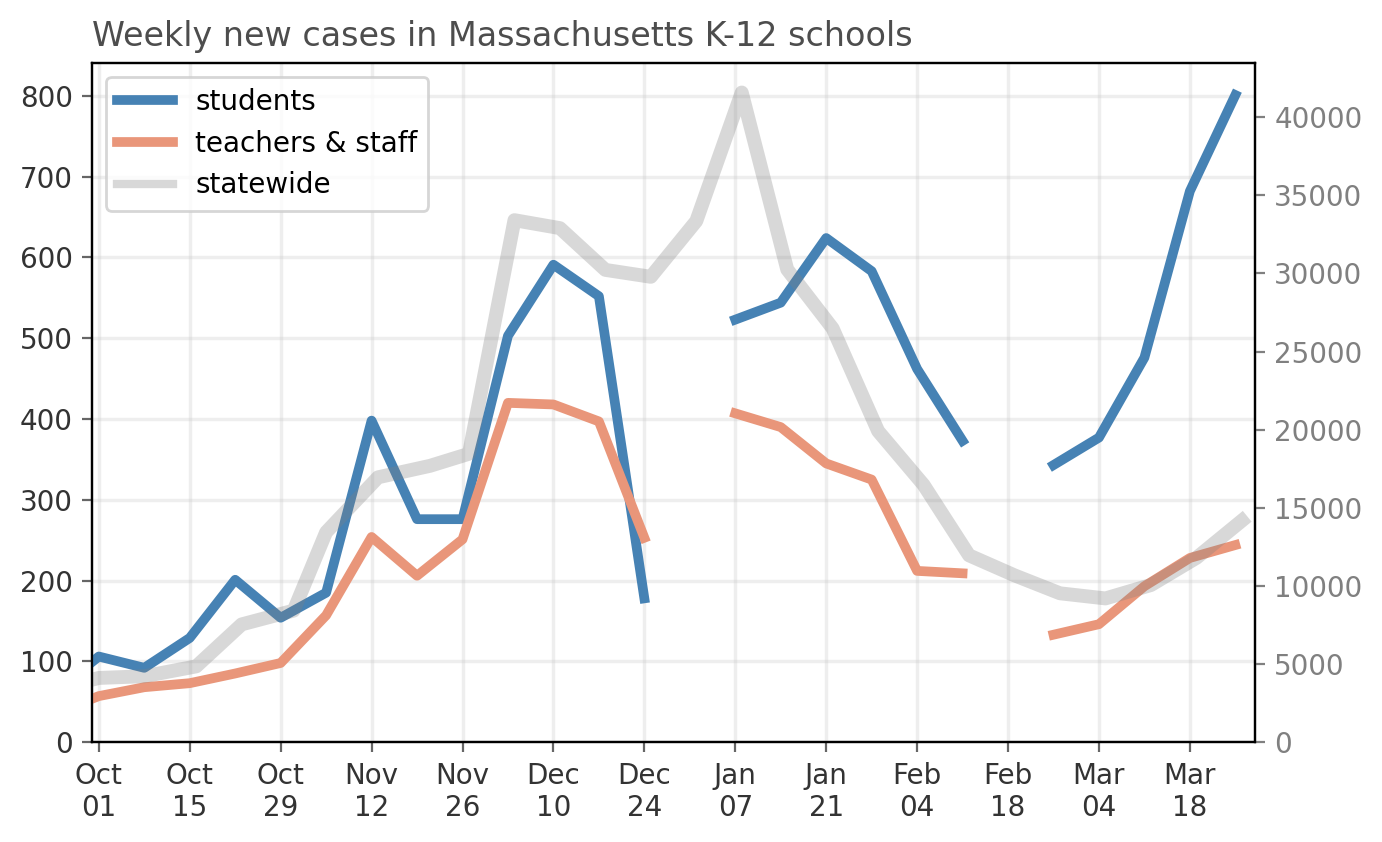

In [35]:
wid = 1
fig, ax = plt.subplots(1,1, figsize=(7.5, 4.5), dpi=200)

cols = ['steelblue','darksalmon']

ax.plot([date_dict[i] for i in sch_dfg['date']],
        sch_dfg['new_cases_students'].rolling(window=wid).mean().values,
        label='students', lw=3.5, color=cols[0], zorder=100)
ax.plot([date_dict[i] for i in sch_dfg['date']],
        sch_dfg['new_cases_employee'].rolling(window=wid).mean().values,
        label='teachers & staff', lw=3.5, color=cols[1], zorder=100)

ax.plot([-100,-101],[-1,-1],lw=3,color='.5',alpha=0.3,
        label='statewide')

ax2 = ax.twinx()
ax2.plot([date_dict[i] for i in city_dfg['date']],
          city_dfg['new_cases_town'].rolling(window=wid).mean().values,
         lw=5,color='.5',alpha=0.3)
ax2.tick_params(labelcolor='.5', color='.5')

dates = [i for i in date_dict.keys() if i > '2020-09-26'][4::14]
ax.set_xticks([date_dict[i] for i in dates])
ax.set_xticklabels([month_dict[i[5:7]]+'\n'+i[8:] for i in dates])
ax.set_xlim(date_dict[sch_dfg['date'].min()]-1+7,date_dict[sch_dfg['date'].max()]+3)

ax.legend(loc=2)
ax.tick_params(labelcolor='.2', color='.4')
ax.grid(linewidth=1.25,color='.75',alpha=0.25)
ax.set_ylim(0)
ax2.set_ylim(0)

ax.set_title('Weekly new cases in Massachusetts K-12 schools',
             x=0,color='.3',ha='left')

plt.savefig('../figs/pngs/ma_k12_schools',dpi=425,bbox_inches='tight')
plt.show()

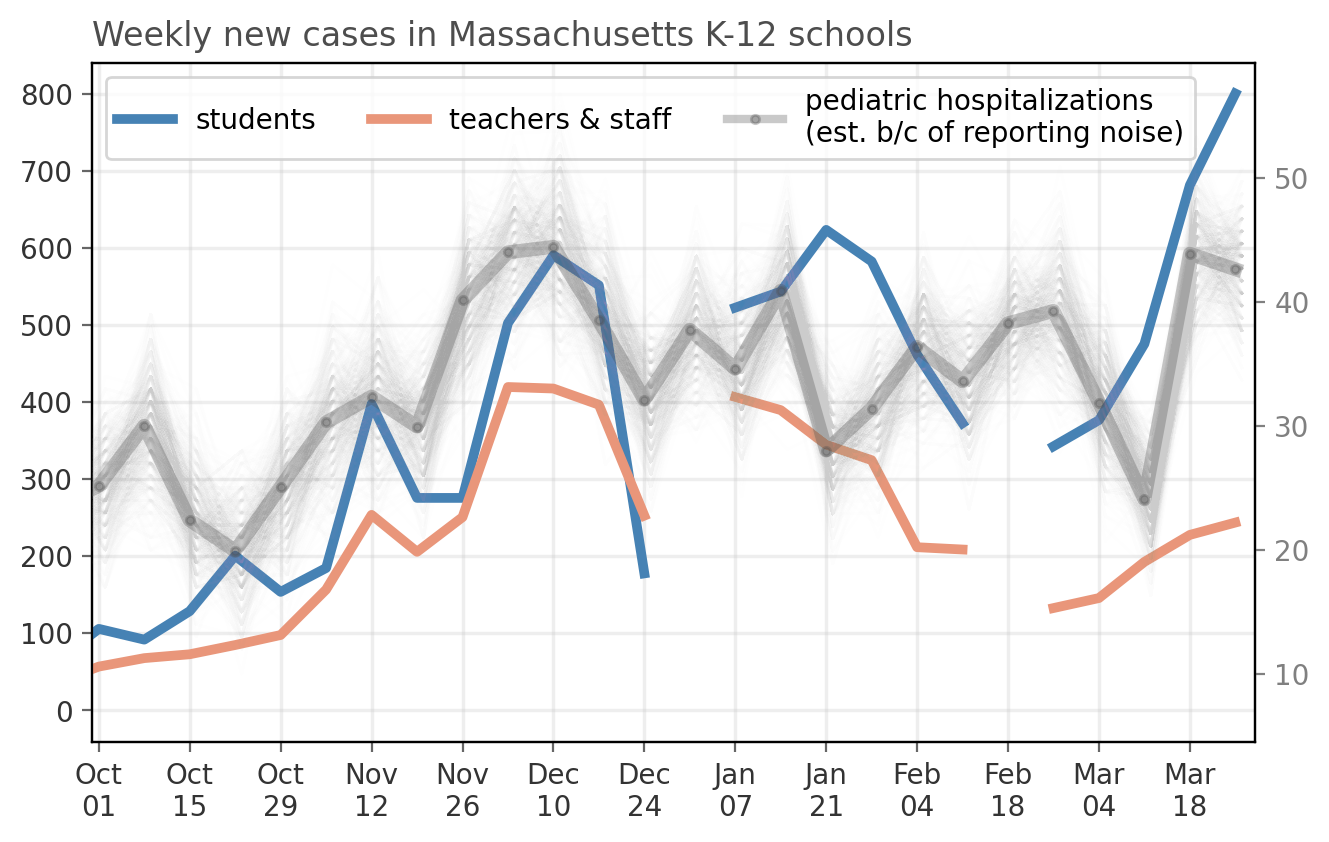

In [36]:
wid = 1
fig, ax = plt.subplots(1,1, figsize=(7.5, 4.5), dpi=200)

cols = ['steelblue','darksalmon']

ax2 = ax.twinx()
child_avg = []
for xi in range(500):
    ma_hosp = hosp.loc[hosp['state']==st].copy()
    ma_hosp[child_col] = [i if i != -999999.0 else np.random.randint(1,5) for i in ma_hosp[child_col]]

    ma_hosp_g = ma_hosp.groupby(['collection_week']).agg({child_col:np.nansum}).reset_index()
    dates = [i for i in ma_hosp_g['collection_week'].values]

    ax2.plot([date_dict[i] for i in dates],ma_hosp_g[child_col].rolling(window=wid).mean().values,
             color='.8', lw=1, alpha=0.01, marker='',zorder=10)
    child_avg.append(ma_hosp_g[child_col].rolling(window=wid).mean().values)

tmp = ma_hosp_g.merge(DATE_DF.rename(columns={'date':'collection_week'}),
                      how='left', on='collection_week')
tmp['pediatric_hosp'] = np.mean(child_avg,axis=0)
tmp = tmp.rename(columns={'collection_week':'date'})
child_hosp = tmp[['date','week','pediatric_hosp']].copy()
sch_dfg_hosp = sch_dfg.merge(child_hosp[['week','pediatric_hosp']], how='left', on='week')

ax2.plot([date_dict[i] for i in sch_dfg_hosp['date']],
         sch_dfg_hosp['pediatric_hosp'].rolling(window=wid).mean().values,
         color='.3',lw=5,alpha=0.3,marker='.',zorder=11)
ax2.tick_params(labelcolor='.5', color='.5')

ax.plot([date_dict[i] for i in sch_dfg['date']],
        sch_dfg['new_cases_students'].rolling(window=wid).mean().values,
        label='students', lw=3.5, color=cols[0], zorder=100)
ax.plot([date_dict[i] for i in sch_dfg['date']],
        sch_dfg['new_cases_employee'].rolling(window=wid).mean().values,
        label='teachers & staff', lw=3.5, color=cols[1], zorder=100)
ax.plot([-100,-101],[-1,-1],lw=3,color='.3',alpha=0.3,marker='.',
        label='pediatric hospitalizations\n(est. b/c of reporting noise)')

dates = [i for i in date_dict.keys() if i > '2020-09-26'][4::14]
ax.set_xticks([date_dict[i] for i in dates])
ax.set_xticklabels([month_dict[i[5:7]]+'\n'+i[8:] for i in dates])
ax.set_xlim(date_dict[sch_dfg['date'].min()]-1+7,date_dict[sch_dfg['date'].max()]+3)

ax.legend(loc=2, ncol=3)
ax.tick_params(labelcolor='.2', color='.4')
ax.grid(linewidth=1.25,color='.75',alpha=0.25)

ax.set_title('Weekly new cases in Massachusetts K-12 schools',
             x=0,color='.3',ha='left')

plt.savefig('../figs/pngs/ma_k12_schools_hosp',dpi=425,bbox_inches='tight')
plt.show()

In [37]:
ma_hosp['city'] = ma_hosp['city'].str.capitalize()

In [38]:
amh_df = city_df.loc[city_df['city']=='Amherst'].copy().reset_index().iloc[:,1:]
non_df = city_df.loc[city_df['city']!='Amherst'].copy().reset_index().iloc[:,1:]
con_df = non_df.loc[non_df['county']=='Hampshire'].copy().reset_index().iloc[:,1:]

amh_df['new_cases_town_per1000'] = amh_df['new_cases_town'] / amh_df['population'] * 1000
non_df['new_cases_town_per1000'] = non_df['new_cases_town'] / non_df['population'] * 1000
con_df['new_cases_town_per1000'] = con_df['new_cases_town'] / con_df['population'] * 1000

In [39]:
nog_df = non_df.groupby('date').agg({'population':'sum','new_cases_town':'sum',
                            'new_cases_town_per1000':'mean'}).reset_index()
nog_df['new_cases_per1000k_town'] = nog_df['new_cases_town'] / nog_df['population'] * 1000

cog_df = con_df.groupby('date').agg({'population':'sum','new_cases_town':'sum',
                            'new_cases_town_per1000':'mean'}).reset_index()
cog_df['new_cases_per1000k_town'] = cog_df['new_cases_town'] / cog_df['population'] * 1000

In [40]:
ma_hosp = hosp.loc[hosp['state']==st].copy()
ma_hosp[child_col] = [i if i != -999999.0 else 1 for i in ma_hosp[child_col]]
ma_hosp_g = ma_hosp.groupby(['collection_week']).agg({adult_col:np.nansum,
                                                      child_col:np.nansum}).reset_index()

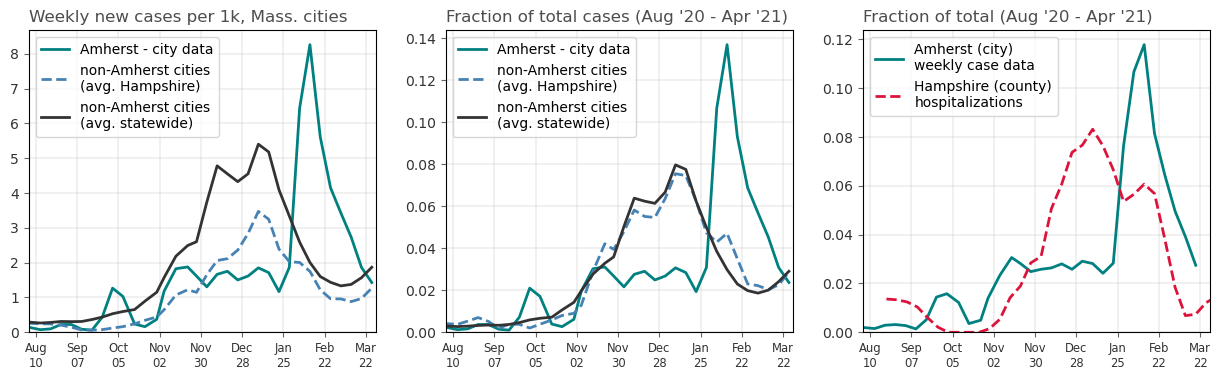

In [41]:
fig, ax = plt.subplots(1,3,figsize=(15.25,4),dpi=100)
wid = 2

ax[0].plot([date_dict[i] for i in amh_df['date']],
           amh_df['new_cases_town_per1000'].rolling(window=wid).mean(),
           label='Amherst - city data', color='teal', lw=2)
ax[0].plot([date_dict[i] for i in cog_df['date']],
           cog_df['new_cases_per1000k_town'].rolling(window=wid).mean(),
           label='non-Amherst cities\n(avg. Hampshire)', color='steelblue', lw=2, linestyle='--')
ax[0].plot([date_dict[i] for i in nog_df['date']],
           nog_df['new_cases_per1000k_town'].rolling(window=wid).mean(),
           label='non-Amherst cities\n(avg. statewide)', color='.2', lw=2)

ax[1].plot([date_dict[i] for i in amh_df['date']],
           amh_df['new_cases_town_per1000'].rolling(window=wid).mean()/\
           amh_df['new_cases_town_per1000'].sum(),
           label='Amherst - city data', color='teal', lw=2)
ax[1].plot([date_dict[i] for i in cog_df['date']],
           cog_df['new_cases_town_per1000'].rolling(window=wid).mean()/\
           cog_df['new_cases_town_per1000'].sum(),
           label='non-Amherst cities\n(avg. Hampshire)', color='steelblue', lw=2, linestyle='--')
ax[1].plot([date_dict[i] for i in nog_df['date']],
           nog_df['new_cases_town_per1000'].rolling(window=wid).mean()/\
           nog_df['new_cases_town_per1000'].sum(),
           label='non-Amherst cities\n(avg. statewide)', color='.2', lw=2)

hcol = 'total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum'
ma_hospx = ma_hosp.loc[ma_hosp.fips_code=='25015'].groupby(['collection_week']).agg({hcol:'sum'}).reset_index()
ss = ma_hospx[hcol].sum()

ax[2].plot([date_dict[i]-7 for i in amh_df['date']],
           amh_df['new_cases_town_per1000'].rolling(window=3).mean()/\
           amh_df['new_cases_town_per1000'].sum(),
           label='Amherst (city)\nweekly case data', color='teal', lw=2)
ax[2].plot([date_dict[i]+7 for i in ma_hospx['collection_week']],
           ma_hospx[hcol].rolling(window=3).mean()/ss,
           label='Hampshire (county)\nhospitalizations', color='crimson', lw=2, linestyle='--')

dates = [i for i in date_dict.keys() if i > '2020-04-26'][21::28]
for a in fig.axes:
    a.set_xticks([date_dict[i] for i in dates])
    a.set_xticklabels([month_dict[i[5:7]]+'\n'+i[8:] for i in dates], fontsize='small')
    a.set_xlim(date_dict['2020-08-05'],date_dict[nog_df['date'].max()]+3)
#     a.set_xlim(date_dict[nog_df['date'].min()]-1+7,date_dict[nog_df['date'].max()]+3)
    a.legend(loc=2)
    a.tick_params(labelcolor='.2', color='.4')
    a.grid(linewidth=1.25,color='.75',alpha=0.25)
    a.set_ylim(0)


ax[0].set_title('Weekly new cases per 1k, Mass. cities',
             x=0,color='.3',ha='left')
ax[1].set_title("Fraction of total cases (Aug '20 - Apr '21)",
             x=0,color='.3',ha='left')
ax[2].set_title("Fraction of total (Aug '20 - Apr '21)",
             x=0,color='.3',ha='left')

plt.savefig('../figs/pngs/amherst_focus.png',dpi=425,bbox_inches='tight')
plt.show()

In [42]:
# hosp_fn = 'https://healthdata.gov/api/views/anag-cw7u/rows.csv?accessType=DOWNLOAD'
# hosp = pd.read_csv(hosp_fn, dtype={'fips_code':str,'zip':str})
# hosp['collection_week'] = hosp.collection_week.astype(str).str[0:4] + '-' +\
#                           hosp.collection_week.astype(str).str[5:7] + '-' +\
#                           hosp.collection_week.astype(str).str[-2:]
# hospx = hosp[['collection_week','state','hospital_name',
#               'city','zip','fips_code']].copy()

In [43]:
# prec = pd.read_csv('/Users/brennan/Downloads/precinct_2018.csv', encoding='latin8')
# prec = prec.loc[prec['state']=='Massachusetts'].copy()
# prec = prec.loc[prec.office=='Governor'].copy().rename(columns={'jurisdiction':'city'})
# prec['city'] = prec['city'].str.replace('N. ','North ')
# prec['city'] = prec['city'].str.replace('W. ','West ')
# prec['city'] = prec['city'].str.replace('E. ','East ')
# prec['city'] = prec['city'].str.replace('S. ','South ')
# prec['city'] = prec['city'].str.replace('Manchester-by-the-Sea','Manchester')
# precg = prec.groupby(['city','party','candidate','year','stage','mode']).agg({'votes':'sum'}).reset_index()

In [44]:
# precg_non = precg.loc[precg['candidate']!='Baker and Polito'].groupby('city').agg({'votes':'sum'}).reset_index()
# precg_non = precg_non.rename(columns={'votes':'votes_not_baker'})

In [45]:
# # use creds to create a client to interact with the Google Drive API
# scope = ['https://spreadsheets.google.com/feeds',
#          'https://www.googleapis.com/auth/drive']

# creds = ServiceAccountCredentials.from_json_keyfile_name('../client_secret.json', scope)
# client = gspread.authorize(creds)

# mass_data = client.open("COVID-data_Massachusetts")
# vaccine_city_age_data = mass_data.worksheet('vaccine_city_age')

In [46]:
# vax_age_dfx = pd.DataFrame(vaccine_city_age_data.get_all_records(default_blank=np.nan))
# vax_age_df = vax_age_dfx[['date', 'county', 'city', 'age_group', 'population', 
#        'atleast_onedose', 'fully_vaccinated','partially_vaccinated']].copy()
# tot_pop = vax_age_df.loc[vax_age_df['age_group']=='Total'][['county','city',
#                           'population']].rename(columns={'population':'total_population'})
# vax_age_df = vax_age_df.merge(tot_pop, how='left', on=['county','city'])
# vax_age_df = vax_age_df.drop_duplicates()

In [47]:
# # vax_city_df = vax_age_df.loc[vax_age_df.age_group.isin(['65-74 Years', '75+ Years'])].copy()
# vax_city_df['city'] = vax_city_df['city'].str.split(' \(').str[0]
# vax_city_df = vax_age_df.loc[vax_age_df.age_group.isin(['Total'])].copy()

# vax_city_df = vax_city_df.groupby(['date', 'county', 'city']).agg({'population':'sum',
#                                                      'atleast_onedose':'sum',
#                                                      'fully_vaccinated':'sum',
#                                                      'partially_vaccinated':'sum'}).reset_index()

In [48]:
import matplotlib.ticker as mtick

In [49]:
# w = 3.5; h = 3.2
# ncols = 3; nrows = 2
# tups = list(it.product(range(nrows), range(ncols)))
# fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100)#, sharex=True)#, sharey=True)
# plt.subplots_adjust(wspace=0.3,hspace=0.3)

# for ai,ag in enumerate(['75+ Years','65-74 Years','50-64 Years','30-49 Years','20-29 Years','0-19 Years']):
#     vax_city_df = vax_age_df.loc[vax_age_df.age_group.isin([ag])].copy()
#     vax_city_df['city'] = vax_city_df['city'].str.split(' \(').str[0]
#     vax_city_df = vax_city_df.merge(precg.loc[precg['candidate']=='Baker and Polito'
#                                              ][['city','votes']].rename(columns={'votes':'votes_baker'}),
#                       how='left', on='city')
#     vax_city_df = vax_city_df.merge(precg_non, how='left', on='city')
#     vax_city_df['votes_total'] = vax_city_df['votes_baker'] + vax_city_df['votes_not_baker']
#     vax_city_df['frac_atleast_onedose'] = vax_city_df['atleast_onedose']/vax_city_df['population']
#     vax_city_df['frac_fully_vaccinated'] = vax_city_df['fully_vaccinated']/vax_city_df['population']
#     vax_city_df['frac_partially_vaccinated'] = vax_city_df['partially_vaccinated']/vax_city_df['population']
#     vax_city_df['frac_votes_not_baker'] = vax_city_df['votes_not_baker']/vax_city_df['total_population']
#     vax_city_df['frac_votes_baker'] = vax_city_df['votes_baker']/vax_city_df['total_population']
#     vax_city_df['share_votes_not_baker'] = vax_city_df['votes_not_baker']/vax_city_df['votes_total']
#     vax_city_df['share_votes_baker'] = vax_city_df['votes_baker']/vax_city_df['votes_total']
#     vax_city_df.loc[vax_city_df['frac_atleast_onedose']>=1,
#                     'frac_atleast_onedose'] = np.random.uniform(0.9,1.0)
#     vax_city_df.loc[vax_city_df['frac_partially_vaccinated']>=1,
#                     'frac_partially_vaccinated'] = np.random.uniform(0.9,1.0)
#     vax_city_df.loc[vax_city_df['frac_fully_vaccinated']>=1,
#                     'frac_fully_vaccinated'] = np.random.uniform(0.9,1.0)
    
#     axi = ax[tups[ai]]
#     d = '2021-03-30'
#     tmp = vax_city_df.loc[vax_city_df['date']==d].drop_duplicates().copy()
#     tmpx = tmp.loc[tmp['total_population']>7200].copy()
#     tmpx = tmpx.sort_values('frac_votes_not_baker').reset_index().iloc[:,1:]
#     cold = plt.cm.coolwarm(tmpx['share_votes_baker'].values)
#     alph = 0.7
#     sizes_d = (np.log10(tmpx['total_population']**3)/max(np.log10(tmpx['total_population']**3)))
#     axi.scatter(tmpx['frac_votes_not_baker'], tmpx['frac_atleast_onedose'], lw=0,
#                 alpha=alph, c=tmpx['share_votes_baker'], cmap='coolwarm', vmin=0.15, vmax=0.85,
#                 ec='.4', s=(sizes_d**10)*250+3)
#     sc = axi.scatter(tmpx['frac_votes_not_baker'], tmpx['frac_atleast_onedose'], lw=(sizes_d**2)*2,
#                 alpha=0.9, c=tmpx['share_votes_baker'], s=(sizes_d**10)*250+3,
#                 cmap='coolwarm', vmin=0.15, vmax=0.85)
#     sc.set_facecolors('none')

# #     axi.set_xlim(0.01,0.49)
#     if ai < 2:
#         axi.set_ylim(0.45, 1.01)
#     elif ai >= 2 and ai < 4:
#         axi.set_ylim(0.125, 0.61)
        
#     if ai > 2:
#         axi.set_xlabel('Percent of total pop. voting\nfor Gov. Baker (by city, 2018)', color='.3')
#     if ai in [0,3]:
#         axi.set_ylabel('Percent of age group with\nat least one dose of vaccine', color='.3')

#     axi.set_title(ag.replace(' Years',' years'), color='.2')
#     axi.yaxis.set_major_formatter(mtick.PercentFormatter(1,decimals=0))
#     axi.xaxis.set_major_formatter(mtick.PercentFormatter(1,decimals=0))
#     axi.tick_params(labelcolor='.2', color='.4')
#     axi.grid(linewidth=1.25,color='.75',alpha=0.25)


# # plt.savefig('../figs/pngs/percentvote_vaccine_age.png',dpi=425,bbox_inches='tight')
# plt.show()

In [50]:
# w = 3.5; h = 3.2
# ncols = 3; nrows = 2
# tups = list(it.product(range(nrows), range(ncols)))
# fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100)#, sharex=True)#, sharey=True)
# plt.subplots_adjust(wspace=0.3,hspace=0.3)

# for ai,ag in enumerate(['75+ Years','65-74 Years','50-64 Years','30-49 Years','20-29 Years','0-19 Years']):
#     vax_city_df = vax_age_df.loc[vax_age_df.age_group.isin([ag])].copy()
#     vax_city_df['city'] = vax_city_df['city'].str.split(' \(').str[0]
#     vax_city_df = vax_city_df.merge(precg.loc[precg['candidate']=='Baker and Polito'
#                                              ][['city','votes']].rename(columns={'votes':'votes_baker'}),
#                       how='left', on='city')
#     vax_city_df = vax_city_df.merge(precg_non, how='left', on='city')
#     vax_city_df['votes_total'] = vax_city_df['votes_baker'] + vax_city_df['votes_not_baker']
#     vax_city_df['frac_atleast_onedose'] = vax_city_df['atleast_onedose']/vax_city_df['population']
#     vax_city_df['frac_fully_vaccinated'] = vax_city_df['fully_vaccinated']/vax_city_df['population']
#     vax_city_df['frac_partially_vaccinated'] = vax_city_df['partially_vaccinated']/vax_city_df['population']
#     vax_city_df['frac_votes_not_baker'] = vax_city_df['votes_not_baker']/vax_city_df['total_population']
#     vax_city_df['frac_votes_baker'] = vax_city_df['votes_baker']/vax_city_df['total_population']
#     vax_city_df['share_votes_not_baker'] = vax_city_df['votes_not_baker']/vax_city_df['votes_total']
#     vax_city_df['share_votes_baker'] = vax_city_df['votes_baker']/vax_city_df['votes_total']
#     vax_city_df.loc[vax_city_df['frac_atleast_onedose']>=1,
#                     'frac_atleast_onedose'] = np.random.uniform(0.9,1.0)
#     vax_city_df.loc[vax_city_df['frac_partially_vaccinated']>=1,
#                     'frac_partially_vaccinated'] = np.random.uniform(0.9,1.0)
#     vax_city_df.loc[vax_city_df['frac_fully_vaccinated']>=1,
#                     'frac_fully_vaccinated'] = np.random.uniform(0.9,1.0)
    
#     axi = ax[tups[ai]]
#     d = '2021-03-30'
#     tmp = vax_city_df.loc[vax_city_df['date']==d].drop_duplicates().copy()
#     tmpx = tmp.loc[tmp['total_population']>7200].copy()
#     tmpx = tmpx.sort_values('frac_votes_not_baker').reset_index().iloc[:,1:]
#     cold = plt.cm.coolwarm(tmpx['share_votes_baker'].values)
#     alph = 0.7
#     sizes_d = (np.log10(tmpx['total_population']**3)/max(np.log10(tmpx['total_population']**3)))
#     axi.scatter(tmpx['share_votes_not_baker'], tmpx['frac_atleast_onedose'], lw=0,
#                 alpha=alph, c=tmpx['share_votes_baker'], cmap='coolwarm', vmin=0.15, vmax=0.85,
#                 ec='.4', s=(sizes_d**10)*250+3)
#     sc = axi.scatter(tmpx['share_votes_not_baker'], tmpx['frac_atleast_onedose'], lw=(sizes_d**2)*2,
#                 alpha=0.9, c=tmpx['share_votes_baker'], s=(sizes_d**10)*250+3,
#                 cmap='coolwarm', vmin=0.15, vmax=0.85)
#     sc.set_facecolors('none')

# #     axi.set_xlim(0.25,0.85)
# #     if ai < 2:
# #         axi.set_ylim(0.45, 1.01)
# #     elif ai >= 2 and ai < 4:
# #         axi.set_ylim(0.125, 0.61)
        
#     if ai > 2:
#         axi.set_xlabel('Vote share for Gov. Baker\n(by city, 2018)', color='.3')
#     if ai in [0,3]:
#         axi.set_ylabel('Percent of age group with\nat least one dose of vaccine', color='.3')

#     axi.set_title(ag.replace(' Years',' years'), color='.2')
#     axi.yaxis.set_major_formatter(mtick.PercentFormatter(1,decimals=0))
#     axi.xaxis.set_major_formatter(mtick.PercentFormatter(1,decimals=0))
#     axi.tick_params(labelcolor='.2', color='.4')
#     axi.grid(linewidth=1.25,color='.75',alpha=0.25)


# # plt.savefig('../figs/pngs/vote_share_vaccine_age.png',dpi=425,bbox_inches='tight')
# plt.show()

In [51]:
# vaccine_city_race_data = mass_data.worksheet('vaccine_city_race')

In [52]:
# vax_race_dfx = pd.DataFrame(vaccine_city_race_data.get_all_records(default_blank=np.nan))
# vax_race_df = vax_race_dfx[['date', 'county', 'city', 'race', 'population', 
#        'atleast_onedose', 'fully_vaccinated','partially_vaccinated']].copy()
# tot_pop = vax_race_df.loc[vax_race_df['race']=='Total'][['county','city',
#                           'population']].rename(columns={'population':'total_population'})
# vax_race_df = vax_race_df.merge(tot_pop, how='left', on=['county','city'])
# vax_race_df = vax_race_df.drop_duplicates().reset_index().iloc[:,1:]

In [53]:
# w = 3.5; h = 3.2
# ncols = 4; nrows = 2
# tups = list(it.product(range(nrows), range(ncols)))
# fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100)#, sharex=True)#, sharey=True)
# plt.subplots_adjust(wspace=0.3,hspace=0.3)

# for ai,ag in enumerate(['White', 'Hispanic', 'Black', 'Asian', 'Multi', 'AI/AN', 'NH/PI', 'Other/Unknown']):
#     vax_city_df = vax_race_df.loc[vax_race_df.race.isin([ag])].copy()
#     vax_city_df['city'] = vax_city_df['city'].str.split(' \(').str[0]
#     vax_city_df = vax_city_df.merge(precg.loc[precg['candidate']=='Baker and Polito'
#                                              ][['city','votes']].rename(columns={'votes':'votes_baker'}),
#                       how='left', on='city')
#     vax_city_df = vax_city_df.merge(precg_non, how='left', on='city')
#     vax_city_df['votes_total'] = vax_city_df['votes_baker'] + vax_city_df['votes_not_baker']
#     vax_city_df['frac_atleast_onedose'] = vax_city_df['atleast_onedose']/vax_city_df['population']
#     vax_city_df['frac_fully_vaccinated'] = vax_city_df['fully_vaccinated']/vax_city_df['population']
#     vax_city_df['frac_partially_vaccinated'] = vax_city_df['partially_vaccinated']/vax_city_df['population']
#     vax_city_df['frac_votes_not_baker'] = vax_city_df['votes_not_baker']/vax_city_df['total_population']
#     vax_city_df['frac_votes_baker'] = vax_city_df['votes_baker']/vax_city_df['total_population']
#     vax_city_df['share_votes_not_baker'] = vax_city_df['votes_not_baker']/vax_city_df['votes_total']
#     vax_city_df['share_votes_baker'] = vax_city_df['votes_baker']/vax_city_df['votes_total']
#     vax_city_df.loc[vax_city_df['frac_atleast_onedose']>=1,
#                     'frac_atleast_onedose'] = np.random.uniform(0.9,1.0)
#     vax_city_df.loc[vax_city_df['frac_partially_vaccinated']>=1,
#                     'frac_partially_vaccinated'] = np.random.uniform(0.9,1.0)
#     vax_city_df.loc[vax_city_df['frac_fully_vaccinated']>=1,
#                     'frac_fully_vaccinated'] = np.random.uniform(0.9,1.0)
    
#     axi = ax[tups[ai]]
#     d = '2021-03-30'
#     tmp = vax_city_df.loc[vax_city_df['date']==d].drop_duplicates().copy()
#     tmpx = tmp.loc[tmp['total_population']>7200].copy()
#     tmpx = tmpx.sort_values('frac_votes_not_baker').reset_index().iloc[:,1:]
#     cold = plt.cm.coolwarm(tmpx['share_votes_baker'].values)
#     alph = 0.7
#     sizes_d = (np.log10(tmpx['total_population']**3)/max(np.log10(tmpx['total_population']**3)))
#     axi.scatter(tmpx['frac_votes_baker'], tmpx['frac_atleast_onedose'], lw=0,
#                 alpha=alph, c=tmpx['share_votes_baker'], cmap='coolwarm', vmin=0.15, vmax=0.85,
#                 ec='.4', s=(sizes_d**10)*250+3)
#     sc = axi.scatter(tmpx['frac_votes_baker'], tmpx['frac_atleast_onedose'], lw=(sizes_d**2)*2,
#                 alpha=0.9, c=tmpx['share_votes_baker'], s=(sizes_d**10)*250+3,
#                 cmap='coolwarm', vmin=0.15, vmax=0.85)
#     sc.set_facecolors('none')

#     axi.set_xlim(0.01,0.49)
# #     if ai < 2:
# #         axi.set_ylim(0.45, 1.01)
# #     elif ai >= 2 and ai < 4:
# #         axi.set_ylim(0.125, 0.61)
        
#     if ai > 3:
#         axi.set_xlabel('Percent of total pop. voting\nfor Gov. Baker (by city, 2018)', color='.3')
#     if ai in [0,4]:
#         axi.set_ylabel('Percent of racial group with\nat least one dose of vaccine', color='.3')

#     axi.set_title(ag.replace(' Years',' years'), color='.2')
#     axi.yaxis.set_major_formatter(mtick.PercentFormatter(1,decimals=0))
#     axi.xaxis.set_major_formatter(mtick.PercentFormatter(1,decimals=0))
#     axi.tick_params(labelcolor='.2', color='.4')
#     axi.grid(linewidth=1.25,color='.75',alpha=0.25)


# # plt.savefig('../figs/pngs/percentvote_vaccine_age.png',dpi=425,bbox_inches='tight')
# plt.show()

In [54]:
# w = 3.5; h = 3.2
# ncols = 4; nrows = 2
# tups = list(it.product(range(nrows), range(ncols)))
# fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100)#, sharex=True)#, sharey=True)
# plt.subplots_adjust(wspace=0.3,hspace=0.3)

# for ai,ag in enumerate(['White', 'Hispanic', 'Black', 'Asian', 'Multi', 'AI/AN', 'NH/PI', 'Other/Unknown']):
#     vax_city_df = vax_race_df.loc[vax_race_df.race.isin([ag])].copy()
#     vax_city_df['city'] = vax_city_df['city'].str.split(' \(').str[0]
#     vax_city_df = vax_city_df.merge(precg.loc[precg['candidate']=='Baker and Polito'
#                                              ][['city','votes']].rename(columns={'votes':'votes_baker'}),
#                       how='left', on='city')
#     vax_city_df = vax_city_df.merge(precg_non, how='left', on='city')
#     vax_city_df['votes_total'] = vax_city_df['votes_baker'] + vax_city_df['votes_not_baker']
#     vax_city_df['frac_atleast_onedose'] = vax_city_df['atleast_onedose']/vax_city_df['population']
#     vax_city_df['frac_fully_vaccinated'] = vax_city_df['fully_vaccinated']/vax_city_df['population']
#     vax_city_df['frac_partially_vaccinated'] = vax_city_df['partially_vaccinated']/vax_city_df['population']
#     vax_city_df['frac_votes_not_baker'] = vax_city_df['votes_not_baker']/vax_city_df['total_population']
#     vax_city_df['frac_votes_baker'] = vax_city_df['votes_baker']/vax_city_df['total_population']
#     vax_city_df['share_votes_not_baker'] = vax_city_df['votes_not_baker']/vax_city_df['votes_total']
#     vax_city_df['share_votes_baker'] = vax_city_df['votes_baker']/vax_city_df['votes_total']
#     vax_city_df.loc[vax_city_df['frac_atleast_onedose']>=1,
#                     'frac_atleast_onedose'] = np.random.uniform(0.9,1.0)
#     vax_city_df.loc[vax_city_df['frac_partially_vaccinated']>=1,
#                     'frac_partially_vaccinated'] = np.random.uniform(0.9,1.0)
#     vax_city_df.loc[vax_city_df['frac_fully_vaccinated']>=1,
#                     'frac_fully_vaccinated'] = np.random.uniform(0.9,1.0)
    
#     axi = ax[tups[ai]]
#     d = '2021-03-30'
#     tmp = vax_city_df.loc[vax_city_df['date']==d].drop_duplicates().copy()
#     tmpx = tmp.loc[tmp['total_population']>7200].copy()
#     tmpx = tmpx.sort_values('frac_votes_not_baker').reset_index().iloc[:,1:]
#     cold = plt.cm.coolwarm(tmpx['share_votes_baker'].values)
#     alph = 0.7
#     sizes_d = (np.log10(tmpx['total_population']**3)/max(np.log10(tmpx['total_population']**3)))
#     axi.scatter(tmpx['share_votes_baker'], tmpx['frac_atleast_onedose'], lw=0,
#                 alpha=alph, c=tmpx['share_votes_baker'], cmap='coolwarm', vmin=0.15, vmax=0.85,
#                 ec='.4', s=(sizes_d**10)*250+3)
#     sc = axi.scatter(tmpx['share_votes_baker'], tmpx['frac_atleast_onedose'], lw=(sizes_d**2)*2,
#                 alpha=0.9, c=tmpx['share_votes_baker'], s=(sizes_d**10)*250+3,
#                 cmap='coolwarm', vmin=0.15, vmax=0.85)
#     sc.set_facecolors('none')

#     axi.set_xlim(0.25,0.85)
# #     if ai < 2:
# #         axi.set_ylim(0.45, 1.01)
# #     elif ai >= 2 and ai < 4:
# #         axi.set_ylim(0.125, 0.61)
        
#     if ai > 3:
#         axi.set_xlabel('Percent of total pop. voting\nfor Gov. Baker (by city, 2018)', color='.3')
#     if ai in [0,4]:
#         axi.set_ylabel('Percent of racial group with\nat least one dose of vaccine', color='.3')

#     axi.set_title(ag.replace(' Years',' years'), color='.2')
#     axi.yaxis.set_major_formatter(mtick.PercentFormatter(1,decimals=0))
#     axi.xaxis.set_major_formatter(mtick.PercentFormatter(1,decimals=0))
#     axi.tick_params(labelcolor='.2', color='.4')
#     axi.grid(linewidth=1.25,color='.75',alpha=0.25)


# # plt.savefig('../figs/pngs/vote_share_vaccine_age.png',dpi=425,bbox_inches='tight')
# plt.show()

In [55]:
# rage_df = vax_race_df.groupby(['race','date']).agg({'population':np.nansum,
#                                           'atleast_onedose':np.nansum,
#                                           'partially_vaccinated':np.nansum,
#                                           'fully_vaccinated':np.nansum}).reset_index()

In [56]:
# w = 3.5; h = 3.2
# ncols = 1; nrows = 1
# fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100)#, sharex=True)#, sharey=True)

# for ai,ag in enumerate(['White', 'Hispanic', 'Black', 'Asian', 'Multi', 
#                         'AI/AN', 'NH/PI', 'Other/Unknown','Total']):
#     r_df = rage_df.loc[rage_df.race.isin([ag])].copy()
#     ax.plot([date_dict[i] for i in r_df['date']],
#             r_df['atleast_onedose'].diff()/r_df['population'], marker='.')

# # axi.set_xlabel('Percent of total pop. voting\nfor Gov. Baker (by city, 2018)', color='.3')
# # axi.set_ylabel('Percent of racial group with\nat least one dose of vaccine', color='.3')

# ax.yaxis.set_major_formatter(mtick.PercentFormatter(1,decimals=0))
# # axi.xaxis.set_major_formatter(mtick.PercentFormatter(1,decimals=0))
# # axi.tick_params(labelcolor='.2', color='.4')
# # axi.grid(linewidth=1.25,color='.75',alpha=0.25)


# # plt.savefig('../figs/pngs/vote_share_vaccine_age.png',dpi=425,bbox_inches='tight')
# plt.show()

In [57]:
# vax_city_df = vax_city_df.groupby(['date', 'county', 'city']).agg({'population':'sum',
#                                                      'atleast_onedose':'sum',
#                                                      'fully_vaccinated':'sum',
#                                                      'partially_vaccinated':'sum'}).reset_index()

In [58]:
# precg_non = precg.loc[precg['candidate']!='Baker and Polito'].groupby('city').agg({'votes':'sum'}).reset_index()
# precg_non = precg_non.rename(columns={'votes':'votes_not_baker'})

In [59]:
# vax_city_df = vax_city_df.merge(precg.loc[precg['candidate']=='Baker and Polito'
#                                          ][['city','votes']].rename(columns={'votes':'votes_baker'}),
#                   how='left', on='city')
# vax_city_df = vax_city_df.merge(precg_non, how='left', on='city')

In [60]:
# vax_city_df = vax_city_df[['date', 'county', 'city', 'population', 'atleast_onedose',
#        'fully_vaccinated', 'partially_vaccinated', 'votes_baker',
#        'votes_not_baker']].copy()

In [61]:
# vax_city_df['votes_total'] = vax_city_df['votes_baker'] + vax_city_df['votes_not_baker']
# vax_city_df['frac_atleast_onedose'] = vax_city_df['atleast_onedose']/vax_city_df['population']
# vax_city_df['frac_fully_vaccinated'] = vax_city_df['fully_vaccinated']/vax_city_df['population']
# vax_city_df['frac_partially_vaccinated'] = vax_city_df['partially_vaccinated']/vax_city_df['population']
# vax_city_df['frac_votes_not_baker'] = vax_city_df['votes_not_baker']/vax_city_df['population']
# vax_city_df['frac_votes_baker'] = vax_city_df['votes_baker']/vax_city_df['population']
# vax_city_df['share_votes_not_baker'] = vax_city_df['votes_not_baker']/vax_city_df['votes_total']
# vax_city_df['share_votes_baker'] = vax_city_df['votes_baker']/vax_city_df['votes_total']

In [62]:
# tmp = vax_city_df.loc[vax_city_df['date']=='2021-03-30'].copy()

In [63]:
# vax_city_df.to_csv('../data/vaccine_bakervotes.csv',index=False)

In [64]:
# prec.to_csv('../data/votes_ma_2018.csv',index=False)